# **Analysis of various Selection Strategies to solve Cold Start Problem with SMS Spam Dataset**




# Setup

## Get Distil and Submodlib from Decile Repo

In [ ]:
# Get DISTIL
!git clone https://github.com/decile-team/distil.git

# Get submodlib
!git clone https://github.com/decile-team/submodlib.git

fatal: destination path 'distil' already exists and is not an empty directory.
fatal: destination path 'submodlib' already exists and is not an empty directory.


## Installations

#### *Restart runtime from here after initial install is complete*

In [ ]:
# Installations for DISTIL
!cd distil && pip install -r distil/requirements/requirements.txt
!pip install -r distil/requirements/requirements.txt

# Required installations
!pip install transformers
!pip install datasets

# Installations for Submodlib
!pip install -e ./submodlib/

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'distil/requirements/requirements.txt'
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
  Using cached sphinxcontrib_bibtex-2.6.2-py3-none-any.whl (40 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached scikit-learn-0.23.0.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Obtaining file:///content/submodlib
  Installing build dependencies ... done
  Checking if build

## Imports

In [ ]:
# Standard imports
import copy
import html
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import random # Import for query size sampling
import re # Import for baseline regex matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import statistics as stat
import string
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import unicodedata

# Imports for datasets
from collections import Counter
from datasets import Dataset as D
from datasets import load_dataset, load_metric, concatenate_datasets
from io import BytesIO
import requests
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from tqdm.auto import tqdm
import zipfile

# Additional Imports
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

# Imports for active learning
sys.path.append('submodlib/')
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, SMI, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling, KMeansSampling   # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Download GloVe vectorizer

In [ ]:
# Get a simple tokenizer from torchtext. Use GloVe embeddings from torchtext, which will automatically download them.
glove_tokenizer     = get_tokenizer("basic_english")
glove_vectorizer    = GloVe(name='840B', dim=300)

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.30MB/s]                            
100%|█████████▉| 2196016/2196017 [06:22<00:00, 5747.99it/s]


The above procedure should take 15-30 minutes. The rest of the code should run quicker.

# Data loading, sampling and pre-processing

## Load data from UCI_ML/Github Repository

In [ ]:
# URL of the CSV file containing the SMS Spam Collection dataset
sms_url = 'https://raw.github.com/ayushbits/robust-aggregate-lfs/main/reef/data/sms/all.csv'

# Load the data, skipping bad lines
sms_df = pd.read_csv(sms_url, on_bad_lines='skip')

# Display SMS dataframe data
sms_df.head(10)

,v1,v2
0,spam,goldviking (29/m) is inviting you to be his fr...
1,ham,"i'm in solihull, | do you want anything?"
2,spam,u have a secret admirer. reveal who thinks u r...
3,ham,hello lover! how goes that new job? are you th...
4,spam,hey i am really horny want to chat or see me n...
5,ham,hi its jess i dont know if you are at work but...
6,ham,then any special there?
7,ham,just nw i came to hme da..
8,ham,shall i get my pouch?
9,ham,doesn't g have class early tomorrow and thus s...


### Rename the columns and labels

In [ ]:
# Rename the columns
sms_df = sms_df.rename(columns={'v2': 'text', 'v1': 'labels'})

# Replace 'spam' with 1 and 'ham' with 0
sms_df['labels'] = sms_df['labels'].replace({'spam': 1, 'ham': 0})

In [ ]:
sms_df.head(10)

,labels,text
0,1,goldviking (29/m) is inviting you to be his fr...
1,0,"i'm in solihull, | do you want anything?"
2,1,u have a secret admirer. reveal who thinks u r...
3,0,hello lover! how goes that new job? are you th...
4,1,hey i am really horny want to chat or see me n...
5,0,hi its jess i dont know if you are at work but...
6,0,then any special there?
7,0,just nw i came to hme da..
8,0,shall i get my pouch?
9,0,doesn't g have class early tomorrow and thus s...


In [ ]:
sms_df['labels'].value_counts()

0     4792
1      710
v1       2
Name: labels, dtype: int64

In [ ]:
len(sms_df)

5504

### Discard data points with invalid label 'v1' (SMS Dataset only)

In [ ]:
# Retain only ham and spam points in sms data
ham_df = sms_df[sms_df['labels']==0]
spam_df = sms_df[sms_df['labels']==1]
binary_df = pd.concat([ham_df, spam_df], ignore_index=True)

In [ ]:
print(ham_df.head())
print(spam_df.head())

  labels                                               text
1      0           i'm in solihull, | do you want anything?
3      0  hello lover! how goes that new job? are you th...
5      0  hi its jess i dont know if you are at work but...
6      0                            then any special there?
7      0                         just nw i came to hme da..
   labels                                               text
0       1  goldviking (29/m) is inviting you to be his fr...
2       1  u have a secret admirer. reveal who thinks u r...
4       1  hey i am really horny want to chat or see me n...
17      1  back 2 work 2morro half term over! can u c me ...
22      1  you won't believe it but it's true. it's incre...


## Define data pre-processing

### Text pre-processing

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set of punctuation special characters to remove from text
punctuation = set(string.punctuation)

# List of stopwords (commonly used words in English)
english_stopwords = set(stopwords.words('english'))

In [ ]:
# Converts all text to lowercase
def to_lower(text):
    return text.lower()

# Removes punctuation from the text
def remove_punc(text):
    return ''.join(x if x not in punctuation else ' ' for x in text)

# Decodes HTML entities and converts accented text to normal
def to_ascii(text):
    decoded_text = html.unescape(text)  # Decoding HTML entities
    return ''.join(x for x in unicodedata.normalize('NFD', decoded_text) if unicodedata.category(x) != 'Mn')

# Removes stopwords
def remove_stopwords(text):
    return ' '.join(x for x in word_tokenize(text) if x not in english_stopwords)

# Removes BOM Unicode
def remove_bom(text):
    return text.replace('\ufeff', '')

# Remove excess whitespace
def remove_xtra(text):
    return ' '.join(text.split()).strip()

# Process the data by making all text lowercase, removing puncuation, removing stopwords, and converting to ascii
def process_data(data):
    data['text'] = data['text'].apply(to_lower)
    data['text'] = data['text'].apply(to_ascii)
    data['text'] = data['text'].apply(remove_punc)
    data['text'] = data['text'].apply(remove_stopwords)
    data['text'] = data['text'].apply(remove_bom)
    data['text'] = data['text'].apply(remove_xtra)
    return data

### GloVe embeddings

In [ ]:
# Create a full dataset wrapper. This will return a dictionary of 3 items:
#   1. glove_embeddings:    The embedding vectors for the sentence, padded to the max length.
#   2. input_mask:          A tensor that denotes the start idx of the padded part of the sequence
#   3. labels:              A single-element tensor denoting the class.
#
# Creating such an object this way will allow us to utilize DISTIL's interfaces without issue and will also be compatible with the model defined above.
class FullDatasetWrapper(Dataset):

    # Here's how we can get embeddings for each sentence. This will create a list of tensors, which will have varying sizes.
    # We will need to pad each tensor for batching, so we will also need to keep track of the actual final token in each batch so that we do not compute on padded input.
    def __init__(self, datalist, labels):
        self.glove_embeddings   = [glove_vectorizer.get_vecs_by_tokens(glove_tokenizer(data_text), lower_case_backup=True) for data_text in datalist] # Convert text into glove embeddings
        self.labels             = torch.tensor(labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length


    def __init__(self, dataframe):
        self.glove_embeddings = []
        valid_labels = []
        for ind in dataframe.index:
            data_text, data_label = dataframe['text'][ind], dataframe['labels'][ind]
            tokens = glove_tokenizer(data_text)
            if not tokens:   # Check if token list is empty
                # print(f"Warning: No tokens for text: {data_text}")
                continue
            glove_embedding = glove_vectorizer.get_vecs_by_tokens(tokens, lower_case_backup=True)
            if glove_embedding.shape[0] == 0:  # Check if no embeddings found
                # print(f"Warning: No embeddings for tokens: {tokens} in text: {data_text}")
                continue
            self.glove_embeddings.append(glove_embedding)
            valid_labels.append(data_label)
        self.labels             = torch.tensor(valid_labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length

    def __getitem__(self, index):
        glove_embedding                                     = self.glove_embeddings[index]                              # Get the glove embeddings for sentence
        padded_glove_embedding                              = torch.zeros(self.pad_length, glove_embedding.shape[1])    # Create a padded tensor of zeros to hold them
        padded_glove_embedding[:glove_embedding.shape[0]]   = glove_embedding                                           # Populate the front of the tensor w/ glove embeddings
        input_mask                                          = torch.tensor(glove_embedding.shape[0])                    # Create a single-element tensor denoting index to start ignoring hidden states
        label                                               = self.labels[index]                                        # Get the label and form the dictionary.
        item_dict                                           =   {"glove_embeddings":    padded_glove_embedding,
                                                                "input_mask":           input_mask,
                                                                "labels":               label}
        return item_dict

    def __len__(self):
        return len(self.glove_embeddings)

### AL Label Removal

In [ ]:
class Labeled_to_unlabel(Dataset):

  def __init__(self, wrapped_dataset):
        self.wrapped_dataset = wrapped_dataset
        # give the words here

  def __getitem__(self, index):

        #label = self.wrapped_dataset[index]['labels']
        data = {key:self.wrapped_dataset[index][key] for key in self.wrapped_dataset[index] if key != 'labels'}

        #data = self.wrapped_dataset[index]
        return data

  def __len__(self):
        return len(self.wrapped_dataset)

## Data split and sampling

In [ ]:
seed_values = [42, 96, 35, 52, 11, 87, 26, 75, 60, 49]

#### *Use Ctrl+F10 from here for experiment re-runs (after changing exp_num)*

In [ ]:
exp_num = 10 # CHANGE ME

In [ ]:
# DEFINE RAND_STATE FOR EXPERIMENT RUN
RAND_STATE = seed_values[exp_num-1]
print('Experiment number: {} \tSeed value = {}'.format(exp_num, RAND_STATE))
with open('logs.txt', 'a') as logfile:
    logfile.write('\n\nExperiment number: {} \tSeed value = {}  [SMS Data]\n'.format(exp_num, RAND_STATE))

Experiment number: 10 	Seed value = 49


### Create test-train split

In [ ]:
# Separate the dataset into two based on the labels
df_0 = binary_df[binary_df['labels'] == 0]
df_1 = binary_df[binary_df['labels'] == 1]

# Specify the features (X) and target (y) columns
X_0, y_0 = df_0['text'], df_0['labels']
X_1, y_1 = df_1['text'], df_1['labels']

# Perform the train-test split while varying the class distribution
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.1, random_state=RAND_STATE, stratify=y_0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.67, random_state=RAND_STATE, stratify=y_1)

# Concatenate the train parts and test parts
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([y_train_0, y_train_1])
X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([y_test_0, y_test_1])

# Create the train_df and test_df DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Shuffle the train and test dataframes
train_df = train_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

### Find data distribution and calculate imbalance factor

In [ ]:
print('\t  Ham   Spam')
train_class_counts = train_df['labels'].value_counts()
print('Training ', train_class_counts[0], ' ', train_class_counts[1])
test_class_counts = test_df['labels'].value_counts()
print('Testing   ', test_class_counts[0], ' ', test_class_counts[1])

	  Ham   Spam
Training  4312   234
Testing    480   476


In [ ]:
print("Rare class to majority class ratio ~ 1 :", round(train_class_counts[0]/train_class_counts[1]))

Rare class to majority class ratio ~ 1 : 18


In [ ]:
a, b = len(test_df), len(train_df)
print("Effective test-train split = {}:{}".format(round((100*a)/(a+b)), round((100*b)/(a+b))))

Effective test-train split = 17:83


### Create query set

In [ ]:
# List of commonly found phrases in sms spam messages
freq_sms_spam_phrases = [
    "Click this link to claim your cash prize",
    "Confirm your account details to continue using our service",
    "Congratulations! You've won a free trial",
    "Earn money quickly", "Exclusive discount code inside",
    "Free gift awaiting you", "Get paid to work from home",
    "Important security notice", "Problem with your payment method",
    "Special limited-time offer", "Suspicious activity detected",
    "To stop receiving these messages, click here",
    "Unclaimed money in your name",
    "Urgent action required to receive your package",
    "Veryify your email and password immediately",
    "Warning: Your account will be deactivated",
    "You are eligible for a refund", "You have an unpaid bill",
    "You're our lucky shopper today",
    "You've been selected for an exclusive offer",
    "Your account has been temporarily locked",
    "Your order is ready for pickup",
    "Your subscription is about to expire",
    "Your trial period is ending", "Your warranty is expired"
]
query_set_size = len(freq_sms_spam_phrases)
query_data = pd.DataFrame({
    'text':freq_sms_spam_phrases, 'labels': [1]*query_set_size
})

## Apply pre-processing

### Apply text processing

In [ ]:
train_processed_df = process_data(train_df)
# train_processed_df.iloc[10:25]
train_processed_df.head()

,text,labels
0,aight see bit,0
1,yup shd haf ard 10 pages add figures got many ...,0
2,ah poop looks like ill prob send laptop get fi...,0
3,true easier,0
4,got call landline number asked come anna nagar...,0


In [ ]:
query_df = process_data(query_data)
query_df.head()

,text,labels
0,click link claim cash prize,1
1,confirm account details continue using service,1
2,congratulations free trial,1
3,earn money quickly,1
4,exclusive discount code inside,1


In [ ]:
test_df = process_data(test_df)

### Get dataset with embeddings

In [ ]:
# GloVe Embeddings for Training Dataset
training_dataset = FullDatasetWrapper(train_processed_df)
# GloVe Embeddings for Query Datas
rare_class_query_set = FullDatasetWrapper(query_df)
# GloVe Embeddings for Testing Dataset
testing_dataset = FullDatasetWrapper(test_df)

# Custom LSTM Model

## Model Definition

In [ ]:
class Average(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, batch_sentence_token_embeddings, input_mask):
        avgs = []
        with torch.no_grad():
            for i in range(batch_sentence_token_embeddings.shape[0]):
                avg = torch.mean(batch_sentence_token_embeddings[i,:input_mask[i],:], dim=0)
                avgs.append(avg)
        return torch.stack(avgs, dim=0)


class SimpleGloVeRNN(nn.Module):

    def __init__(self, num_classes, hidden_dim=512, embedding_dim=256, num_rnn_stacks=1, num_mlp_layers=1):

        super().__init__()
        self.average  = Average()
        self.rnn      = nn.LSTM(batch_first=True, input_size=300, hidden_size=hidden_dim, num_layers=num_rnn_stacks)
        self.activ    = nn.ReLU()

        mlp_layers  = []
        for i in range(num_mlp_layers - 1):
            linear      = nn.Linear(hidden_dim, hidden_dim)
            bn          = nn.BatchNorm1d(hidden_dim)
            mlp_layers.append(linear)
            mlp_layers.append(bn)
            mlp_layers.append(self.activ)
        embed_linear    = nn.Linear(hidden_dim, embedding_dim)
        embed_bn        = nn.BatchNorm1d(hidden_dim)
        mlp_layers.append(embed_linear)
        mlp_layers.append(embed_bn)

        self.mlp            = nn.Sequential(*mlp_layers)
        self.cls            = nn.Linear(embedding_dim, num_classes)
        self.embedding_dim  = embedding_dim
        self.hidden_dim     = hidden_dim


    def get_embedding_dim(self):
        return self.embedding_dim


    def forward(self, glove_embeddings, input_mask, labels=None, freeze=False, last=False):

        if freeze:
            with torch.no_grad():
                ignore_this         = self.average(glove_embeddings, input_mask)
                hidden_states, _    = self.rnn(glove_embeddings)
                # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()
                last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1) # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
                if last_hidden_states.size(1) == 1:
                    last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
                else:
                    last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
                # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
                sentence_embed      = self.mlp(last_hidden_states)
        else:
            ignore_this         = self.average(glove_embeddings, input_mask)                                                            # Added so we can use hooks to get input values for DISTIL's SMI.
            hidden_states, _    = self.rnn(glove_embeddings)                                                                            # Apply RNN
            # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
            last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
            if last_hidden_states.size(1) == 1:
                last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
            else:
                last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
            # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
            sentence_embed      = self.mlp(last_hidden_states)                                                                          # Then, apply the MLP on top of the hidden states.
        logits  = self.cls(self.activ(sentence_embed))
        if last:
            return logits, sentence_embed
        else:
            return logits

## Custom Training Method

In [ ]:
class data_train:

    def __init__(self, num_cls=2, hidden_dim=256, embedding_dim=256, num_rnn_stacks=2, mlp_layers=2, batch_size=20) -> None:
        self.model = SimpleGloVeRNN(num_cls, hidden_dim, embedding_dim, num_rnn_stacks, mlp_layers)
        self.num_cls = num_cls
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_stacks = num_rnn_stacks
        self.mlp_layers = mlp_layers
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def get_param_count(self):
        # How many parameters? Should be MUCH less than BERT (110 million)! Can configure above params to make the model larger/smaller.
        param_count = 0
        for param in self.model.parameters():
            size_list   = param.size()
            param_count += torch.prod(torch.tensor(size_list)).item()
        print("Parameters:", F"{param_count:,}")
        return param_count

    def check_batching(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output = self.model(**batch_dict)
            print(output.shape)

    def train(self, training_dataset, epochs=150, lr=1e-2):
        dataloader = DataLoader(training_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.model.train()
        losses = []
        for i in range(epochs):
            epoch_loss, num_batches = 0, 0
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                optimizer.zero_grad()
                out   = self.model(**batch_dict)
                loss  = torch.nn.functional.cross_entropy(out, batch_dict["labels"])
                loss.backward()
                optimizer.step()
                epoch_loss, num_batches = epoch_loss+loss.item(), num_batches+1
            avg_loss = epoch_loss/num_batches if num_batches>0 else 0
            if (i+1)%5==0:
                print('Epoch:', (i+1), '\tLoss =', avg_loss)
            losses.append(avg_loss)
        self.model.eval()
        return losses

    def verify_output_emeddings(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output, embeddings = self.model(**batch_dict, last=True, freeze=True)
            print(output)
            print(embeddings.shape)

    def get_test_metrics(self, testing_dataset):
        dataloader = DataLoader(testing_dataset, batch_size=self.batch_size, shuffle=False)
        # Initialize counters
        tp = fp = fn = tn = 0

        self.model.eval()
        with torch.no_grad():
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                # Get model outputs
                outputs = self.model(**batch_dict)
                # Calculate predictions from outputs (assuming binary classification with threshold at 0.5)
                # Modify the threshold and prediction calculation if necessary
                predictions = torch.argmax(outputs, dim=1)
                # Get true labels
                true_labels = batch_dict["labels"]
                # Update confusion matrix
                conf_mat = confusion_matrix(true_labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1])
                tn_, fp_, fn_, tp_ = conf_mat.ravel() if conf_mat.size == 4 else (0, 0, 0, 0)
                tp, fp, fn, tn = tp+tp_, fp+fp_, fn+fn_, tn+tn_

        acc = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

        metrics = {
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'acc': acc, 'f1': f1,
            'ppv': ppv, 'tpr': tpr, 'fpr': fpr, 'fnr': fnr,
            'tnr': tnr, 'npv': npv, 'fdr': fdr, 'mcc': mcc
        }

        return metrics


In [ ]:
metric_dict = {
    'tp': "True Positive Count", 'fp': 'False Positive Count',
    'fn': "False Negative Count", 'tn': 'True Negative Count',
    'acc': "Accuracy", 'f1': 'F1-score | F-measure',
    'ppv': "Positive Predictive Value | Precision",
    'tpr': 'True Positive Rate | Recall | Sensitivity',
    'fpr': "False Positive Rate | Type I error",
    'fnr': 'False Negative Rate | Type II error',
    'tnr': "True Negative Rate | Specificity",
    'npv': 'Negative Predictive Value', 'fdr': "False Discovery Rate",
    'mcc': 'Matthews Correlation Coefficient',

}
metric_dict

{'tp': 'True Positive Count',
 'fp': 'False Positive Count',
 'fn': 'False Negative Count',
 'tn': 'True Negative Count',
 'acc': 'Accuracy',
 'f1': 'F1-score | F-measure',
 'ppv': 'Positive Predictive Value | Precision',
 'tpr': 'True Positive Rate | Recall | Sensitivity',
 'fpr': 'False Positive Rate | Type I error',
 'fnr': 'False Negative Rate | Type II error',
 'tnr': 'True Negative Rate | Specificity',
 'npv': 'Negative Predictive Value',
 'fdr': 'False Discovery Rate',
 'mcc': 'Matthews Correlation Coefficient'}

# Active Learning

## Define Selection Strategy arguments

In [ ]:
budget = round(sum(train_class_counts)/33.333) # Budget is set to 3% of the total training dataset
print(budget)

136


In [ ]:
selection_strategy_args = {
    'device':        "cpu",                  # Use the device used in training
    'batch_size':    20,                    # Use the batch size used in training
    'metric':        'cosine',             # Use cosine similarity when determining the likeness of two data points
    'optimizer':     'LazyGreedy',          # When doing submodular maximization, use the lazy greedy optimizer
    'embedding_type': 'features',          # IMPORTANT: NEED TO USE PRETRAINED GLOVE FEATURES FOR COLD START SELECTION!
    'layer_name':    'average'             # We can do so by specifying the layer we wish to extract those features from.
}

## Facility Location: Second variant (query-set Q)

In [ ]:
LSTM_fl2mi = data_train()

### FLQMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl2mi'
selection_strategy_args['device'] = LSTM_fl2mi.device
fl2mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl2mi.model, LSTM_fl2mi.num_cls, selection_strategy_args)
fl2mi_selected_idx = fl2mi_selection_strategy.select(budget)
fl2mi_human_labeled_dataset = Subset(training_dataset, fl2mi_selected_idx)

fl2mi_class_counts = [0 for x in range(LSTM_fl2mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl2mi_human_labeled_dataset:
    fl2mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLQMI')
for class_idx, class_count in enumerate(fl2mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLQMI
Class 0 count: 124
Class 1 count: 12


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLQMI \n')
    for class_idx, class_count in enumerate(fl2mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLQMI Selection

In [ ]:
losses_fl2mi = LSTM_fl2mi.train(fl2mi_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.0826190933585167
Epoch: 10 	Loss = 0.040572836462940486
Epoch: 15 	Loss = 0.026242602350456373
Epoch: 20 	Loss = 0.019144798762031963
Epoch: 25 	Loss = 0.014987784171743053
Epoch: 30 	Loss = 0.012242672565792288


### Test Performance - FLQMI

In [ ]:
fl2mi_metrics = LSTM_fl2mi.get_test_metrics(testing_dataset)

In [ ]:
fl2mi_metrics

{'tp': 167,
 'fp': 3,
 'fn': 309,
 'tn': 476,
 'acc': 0.6732984293193718,
 'f1': 0.5170278637770898,
 'ppv': 0.9823529411764705,
 'tpr': 0.35084033613445376,
 'fpr': 0.006263048016701462,
 'fnr': 0.6491596638655462,
 'tnr': 0.9937369519832986,
 'npv': 0.6063694267515923,
 'fdr': 0.01764705882352941,
 'mcc': 0.4504002186887941}

In [ ]:
fl2mi_metrics['name'] = 'FLQMI'

## Facility Location: First variant (ground-set V)

In [ ]:
LSTM_fl1mi = data_train()

### FLVMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl1mi'
selection_strategy_args['device'] = LSTM_fl1mi.device
fl1mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl1mi.model, LSTM_fl1mi.num_cls, selection_strategy_args)
fl1mi_selected_idx = fl1mi_selection_strategy.select(budget)
fl1mi_human_labeled_dataset = Subset(training_dataset, fl1mi_selected_idx)

fl1mi_class_counts = [0 for x in range(LSTM_fl1mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl1mi_human_labeled_dataset:
    fl1mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLVMI')
for class_idx, class_count in enumerate(fl1mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLVMI
Class 0 count: 125
Class 1 count: 11


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLVMI \n')
    for class_idx, class_count in enumerate(fl1mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLVMI Selection

In [ ]:
losses_fl1mi = LSTM_fl1mi.train(fl1mi_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.09779678391558784
Epoch: 10 	Loss = 0.04775751967515264
Epoch: 15 	Loss = 0.030202783112015043
Epoch: 20 	Loss = 0.021740786465150968
Epoch: 25 	Loss = 0.016794119429375445
Epoch: 30 	Loss = 0.013616827981812614


### Test Performance - FLVMI

In [ ]:
fl1mi_metrics = LSTM_fl1mi.get_test_metrics(testing_dataset)

In [ ]:
fl1mi_metrics

{'tp': 237,
 'fp': 3,
 'fn': 239,
 'tn': 476,
 'acc': 0.7465968586387435,
 'f1': 0.6620111731843575,
 'ppv': 0.9875,
 'tpr': 0.49789915966386555,
 'fpr': 0.006263048016701462,
 'fnr': 0.5021008403361344,
 'tnr': 0.9937369519832986,
 'npv': 0.6657342657342658,
 'fdr': 0.0125,
 'mcc': 0.5667041153902843}

In [ ]:
fl1mi_metrics['name'] = 'FLVMI'

## Log Determinant

In [ ]:
LSTM_logdetmi = data_train()

### LogDetMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'logdetmi'
selection_strategy_args['device'] = LSTM_logdetmi.device
logdetmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_logdetmi.model, LSTM_logdetmi.num_cls, selection_strategy_args)
logdetmi_selected_idx = logdetmi_selection_strategy.select(budget)
logdetmi_human_labeled_dataset = Subset(training_dataset, logdetmi_selected_idx)

logdetmi_class_counts = [0 for x in range(LSTM_logdetmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in logdetmi_human_labeled_dataset:
    logdetmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: LogDetMI')
for class_idx, class_count in enumerate(logdetmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: LogDetMI
Class 0 count: 121
Class 1 count: 15


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: LogDetMI \n')
    for class_idx, class_count in enumerate(logdetmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on LogDetMI Selection

In [ ]:
losses_logdetmi = LSTM_logdetmi.train(logdetmi_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.09612796029874257
Epoch: 10 	Loss = 0.04494721336024148
Epoch: 15 	Loss = 0.028033933203135217
Epoch: 20 	Loss = 0.019948609173297882
Epoch: 25 	Loss = 0.01528834312089852
Epoch: 30 	Loss = 0.01230843338583197


### Test Performance - LogDetMI

In [ ]:
logdetmi_metrics = LSTM_logdetmi.get_test_metrics(testing_dataset)

In [ ]:
logdetmi_metrics

{'tp': 214,
 'fp': 1,
 'fn': 262,
 'tn': 478,
 'acc': 0.724607329842932,
 'f1': 0.6193921852387844,
 'ppv': 0.9953488372093023,
 'tpr': 0.4495798319327731,
 'fpr': 0.0020876826722338203,
 'fnr': 0.5504201680672269,
 'tnr': 0.9979123173277662,
 'npv': 0.6459459459459459,
 'fdr': 0.004651162790697674,
 'mcc': 0.5356998980994057}

In [ ]:
logdetmi_metrics['name'] = 'LogDetMI'

## Graph Cut

In [ ]:
LSTM_gcmi = data_train()

### GCMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'gcmi'
selection_strategy_args['device'] = LSTM_gcmi.device
gcmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_gcmi.model, LSTM_gcmi.num_cls, selection_strategy_args)
gcmi_selected_idx = gcmi_selection_strategy.select(budget)
gcmi_human_labeled_dataset = Subset(training_dataset, gcmi_selected_idx)

gcmi_class_counts = [0 for x in range(LSTM_gcmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in gcmi_human_labeled_dataset:
    gcmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: GCMI')
for class_idx, class_count in enumerate(gcmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: GCMI
Class 0 count: 91
Class 1 count: 45


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: GCMI \n')
    for class_idx, class_count in enumerate(gcmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on GCMI Selection

In [ ]:
losses_gcmi = LSTM_gcmi.train(gcmi_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.114822618663311
Epoch: 10 	Loss = 0.05177157797983715
Epoch: 15 	Loss = 0.03162019380501339
Epoch: 20 	Loss = 0.022235644981265068
Epoch: 25 	Loss = 0.0170000305931483
Epoch: 30 	Loss = 0.013681041209825448


### Test Performance - GCMI

In [ ]:
gcmi_metrics = LSTM_gcmi.get_test_metrics(testing_dataset)

In [ ]:
gcmi_metrics

{'tp': 408,
 'fp': 58,
 'fn': 68,
 'tn': 421,
 'acc': 0.8680628272251308,
 'f1': 0.8662420382165605,
 'ppv': 0.8755364806866953,
 'tpr': 0.8571428571428571,
 'fpr': 0.12108559498956159,
 'fnr': 0.14285714285714285,
 'tnr': 0.8789144050104384,
 'npv': 0.8609406952965235,
 'fdr': 0.12446351931330472,
 'mcc': 0.7362671891321784}

In [ ]:
gcmi_metrics['name'] = 'GCMI'

## RegEx Baseline

In [ ]:
LSTM_regex = data_train()

### Custom RegEx Sampling

In [ ]:
# Extract only the text (not labels) from the train_dataset after text processing
full_data_texts = train_processed_df['text'].tolist()
query_texts = query_df['text'].tolist()

# Function to count regex matches
def count_regex_matches(text, patterns):
    return sum([1 if re.search(pattern, text) else 0 for pattern in patterns])

# Count matches for each item in full_data_texts
match_counts = [count_regex_matches(text, query_texts) for text in full_data_texts]

# Extract the top k indices
regex_selected_idx = sorted(range(len(match_counts)), key=lambda i: match_counts[i], reverse=True)[:budget]
print(len(regex_selected_idx), regex_selected_idx[:budget//5])

136 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
regex_human_labeled_dataset = FullDatasetWrapper(train_processed_df.iloc[regex_selected_idx])
regex_class_counts = [0 for x in range(LSTM_regex.num_cls)] # Comment if repeating selection
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in regex_human_labeled_dataset:
    regex_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: RegEx Baseline')
for class_idx, class_count in enumerate(regex_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: RegEx Baseline
Class 0 count: 131
Class 1 count: 5


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: RegEx Baseline \n')
    for class_idx, class_count in enumerate(regex_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on RegEx Selection

In [ ]:
losses_regex = LSTM_regex.train(regex_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.06779911369085312
Epoch: 10 	Loss = 0.03274949640035629
Epoch: 15 	Loss = 0.021168249260102
Epoch: 20 	Loss = 0.015492128740463938
Epoch: 25 	Loss = 0.01215486228466034
Epoch: 30 	Loss = 0.009970130398869514


### Test Performance - RegEx

In [ ]:
regex_metrics = LSTM_regex.get_test_metrics(testing_dataset)

In [ ]:
regex_metrics

{'tp': 80,
 'fp': 0,
 'fn': 396,
 'tn': 479,
 'acc': 0.5853403141361256,
 'f1': 0.28776978417266186,
 'ppv': 1.0,
 'tpr': 0.16806722689075632,
 'fpr': 0.0,
 'fnr': 0.8319327731092437,
 'tnr': 1.0,
 'npv': 0.5474285714285714,
 'fdr': 0.0,
 'mcc': 0.3033229333907483}

In [ ]:
regex_metrics['name'] = 'RegEx'

## Random Strategy

In [ ]:
LSTM_random = data_train()

### Random Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_random.device
random_selection_strategy = RandomSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_random.model, LSTM_random.num_cls, selection_strategy_args)
random_selected_idx = random_selection_strategy.select(budget)
random_human_labeled_dataset = Subset(training_dataset, random_selected_idx)

random_class_counts = [0 for x in range(LSTM_random.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in random_human_labeled_dataset:
    random_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Random')
for class_idx, class_count in enumerate(random_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Random
Class 0 count: 132
Class 1 count: 4


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Random \n')
    for class_idx, class_count in enumerate(random_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Random Selection

In [ ]:
losses_random = LSTM_random.train(random_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.0664592060659613
Epoch: 10 	Loss = 0.03322620902742658
Epoch: 15 	Loss = 0.02170340982931001
Epoch: 20 	Loss = 0.015940607525408268
Epoch: 25 	Loss = 0.012569105252623558
Epoch: 30 	Loss = 0.01033415671970163


### Test Performance - Random

In [ ]:
random_metrics = LSTM_random.get_test_metrics(testing_dataset)

In [ ]:
random_metrics

{'tp': 4,
 'fp': 0,
 'fn': 472,
 'tn': 479,
 'acc': 0.5057591623036649,
 'f1': 0.016666666666666666,
 'ppv': 1.0,
 'tpr': 0.008403361344537815,
 'fpr': 0.0,
 'fnr': 0.9915966386554622,
 'tnr': 1.0,
 'npv': 0.5036803364879074,
 'fdr': 0.0,
 'mcc': 0.0650584957530243}

In [ ]:
random_metrics['name'] = 'Random'

## BADGE - Batch Active learning by Diverse Gradient Embeddings

In [ ]:
LSTM_badge = data_train()

### BADGE Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_badge.device
badge_selection_strategy = BADGE(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_badge.model, LSTM_badge.num_cls, selection_strategy_args)
badge_selected_idx = badge_selection_strategy.select(budget)
badge_human_labeled_dataset = Subset(training_dataset, badge_selected_idx)

badge_class_counts = [0 for x in range(LSTM_badge.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in badge_human_labeled_dataset:
    badge_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: BADGE')
for class_idx, class_count in enumerate(badge_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: BADGE
Class 0 count: 124
Class 1 count: 12


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: BADGE \n')
    for class_idx, class_count in enumerate(badge_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on BADGE Selection

In [ ]:
losses_badge = LSTM_badge.train(badge_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.10118393493550164
Epoch: 10 	Loss = 0.04873605711119516
Epoch: 15 	Loss = 0.030449865651982173
Epoch: 20 	Loss = 0.021580731762307032
Epoch: 25 	Loss = 0.016514978504606655
Epoch: 30 	Loss = 0.01328419880675418


### Test Performance - BADGE

In [ ]:
badge_metrics = LSTM_badge.get_test_metrics(testing_dataset)

In [ ]:
badge_metrics

{'tp': 195,
 'fp': 1,
 'fn': 281,
 'tn': 478,
 'acc': 0.7047120418848167,
 'f1': 0.5803571428571429,
 'ppv': 0.9948979591836735,
 'tpr': 0.4096638655462185,
 'fpr': 0.0020876826722338203,
 'fnr': 0.5903361344537815,
 'tnr': 0.9979123173277662,
 'npv': 0.6297760210803689,
 'fdr': 0.00510204081632653,
 'mcc': 0.5045812485781821}

In [ ]:
badge_metrics['name'] = 'BADGE'

## Entropy Sampling

In [ ]:
LSTM_entropy = data_train()

### Entropy Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_entropy.device
entropy_selection_strategy = EntropySampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_entropy.model, LSTM_entropy.num_cls, selection_strategy_args)
entropy_selected_idx = entropy_selection_strategy.select(budget)
entropy_human_labeled_dataset = Subset(training_dataset, entropy_selected_idx)

entropy_class_counts = [0 for x in range(LSTM_entropy.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in entropy_human_labeled_dataset:
    entropy_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Entropy')
for class_idx, class_count in enumerate(entropy_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Entropy
Class 0 count: 112
Class 1 count: 24


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Entropy \n')
    for class_idx, class_count in enumerate(entropy_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Entropy Selection

In [ ]:
losses_entropy = LSTM_entropy.train(entropy_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.12549564668110438
Epoch: 10 	Loss = 0.06271427177957126
Epoch: 15 	Loss = 0.039365941658616066
Epoch: 20 	Loss = 0.02796687318810395
Epoch: 25 	Loss = 0.021391771467668668
Epoch: 30 	Loss = 0.017148851150912896


### Test Performance - Entropy

In [ ]:
entropy_metrics = LSTM_entropy.get_test_metrics(testing_dataset)

In [ ]:
entropy_metrics

{'tp': 203,
 'fp': 1,
 'fn': 273,
 'tn': 478,
 'acc': 0.7130890052356021,
 'f1': 0.5970588235294118,
 'ppv': 0.9950980392156863,
 'tpr': 0.4264705882352941,
 'fpr': 0.0020876826722338203,
 'fnr': 0.5735294117647058,
 'tnr': 0.9979123173277662,
 'npv': 0.6364846870838882,
 'fdr': 0.004901960784313725,
 'mcc': 0.5177189512568112}

In [ ]:
entropy_metrics['name'] = 'Entropy'

## Least Confidence Sampling

In [ ]:
LSTM_leastconf = data_train()

### Least Confidence Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_leastconf.device
leastconf_selection_strategy = LeastConfidenceSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_leastconf.model, LSTM_leastconf.num_cls, selection_strategy_args)
leastconf_selected_idx = leastconf_selection_strategy.select(budget)
leastconf_human_labeled_dataset = Subset(training_dataset, leastconf_selected_idx)

leastconf_class_counts = [0 for x in range(LSTM_leastconf.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in leastconf_human_labeled_dataset:
    leastconf_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Least Confidence')
for class_idx, class_count in enumerate(leastconf_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Least Confidence
Class 0 count: 113
Class 1 count: 23


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Least Confidence \n')
    for class_idx, class_count in enumerate(leastconf_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Least Confidence Selection

In [ ]:
losses_leastconf = LSTM_leastconf.train(leastconf_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.0936661788395473
Epoch: 10 	Loss = 0.04394315129944256
Epoch: 15 	Loss = 0.027620712827358927
Epoch: 20 	Loss = 0.019878573715686798
Epoch: 25 	Loss = 0.015426020537103926
Epoch: 30 	Loss = 0.01254877754087959


### Test Performance - Least Confidence

In [ ]:
leastconf_metrics = LSTM_leastconf.get_test_metrics(testing_dataset)

In [ ]:
leastconf_metrics

{'tp': 295,
 'fp': 5,
 'fn': 181,
 'tn': 474,
 'acc': 0.8052356020942408,
 'f1': 0.7603092783505154,
 'ppv': 0.9833333333333333,
 'tpr': 0.6197478991596639,
 'fpr': 0.010438413361169102,
 'fnr': 0.3802521008403361,
 'tnr': 0.9895615866388309,
 'npv': 0.7236641221374046,
 'fdr': 0.016666666666666666,
 'mcc': 0.6563385224514249}

In [ ]:
leastconf_metrics['name'] = 'Least_Conf'

## Margin Sampling

In [ ]:
LSTM_margin = data_train()

### Margin Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_margin.device
margin_selection_strategy = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_margin.model, LSTM_margin.num_cls, selection_strategy_args)
margin_selected_idx = margin_selection_strategy.select(budget)
margin_human_labeled_dataset = Subset(training_dataset, margin_selected_idx)

margin_class_counts = [0 for x in range(LSTM_margin.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in margin_human_labeled_dataset:
    margin_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Margin')
for class_idx, class_count in enumerate(margin_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Margin
Class 0 count: 132
Class 1 count: 4


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Margin \n')
    for class_idx, class_count in enumerate(margin_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Margin Selection

In [ ]:
losses_margin = LSTM_margin.train(margin_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.06870538688131742
Epoch: 10 	Loss = 0.034831838948386054
Epoch: 15 	Loss = 0.023006769961544445
Epoch: 20 	Loss = 0.016980384343436787
Epoch: 25 	Loss = 0.013393273976232325
Epoch: 30 	Loss = 0.01102226839533874


### Test Performance - Margin

In [ ]:
margin_metrics = LSTM_margin.get_test_metrics(testing_dataset)

In [ ]:
margin_metrics

{'tp': 3,
 'fp': 0,
 'fn': 473,
 'tn': 479,
 'acc': 0.5047120418848168,
 'f1': 0.012526096033402923,
 'ppv': 1.0,
 'tpr': 0.0063025210084033615,
 'fpr': 0.0,
 'fnr': 0.9936974789915967,
 'tnr': 1.0,
 'npv': 0.5031512605042017,
 'fdr': 0.0,
 'mcc': 0.05631271072974878}

In [ ]:
margin_metrics['name'] = 'Margin'

## KMeans Sampling

In [ ]:
LSTM_kmeans = data_train()

### KMeans Subset Selection

In [ ]:
selection_strategy_args['device']         = LSTM_kmeans.device
selection_strategy_args['representation'] = "raw"

# Get average glove embeddings of all unlabeled points, which can be done via the model
dummy_strategy      = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
extracted_features  = dummy_strategy.get_feature_embedding(Labeled_to_unlabel(training_dataset), True, layer_name='average')

class TensorDataset(Dataset):
    def __init__(self, feature_tensor):
        self.feature_tensor = feature_tensor


    def __getitem__(self, index):
        return self.feature_tensor[index]


    def __len__(self):
        return self.feature_tensor.shape[0]

sel_dataset = TensorDataset(extracted_features)
kmeans_selection_strategy = KMeansSampling(sel_dataset, sel_dataset, LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
kmeans_selected_idx = kmeans_selection_strategy.select(budget)
kmeans_human_labeled_dataset = Subset(training_dataset, kmeans_selected_idx)

kmeans_class_counts = [0 for x in range(LSTM_kmeans.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in kmeans_human_labeled_dataset:
    kmeans_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: KMeans')
for class_idx, class_count in enumerate(kmeans_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: KMeans
Class 0 count: 129
Class 1 count: 7


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: KMeans \n')
    for class_idx, class_count in enumerate(kmeans_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on KMeans Selection

In [ ]:
losses_kmeans = LSTM_kmeans.train(kmeans_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.09197428928954261
Epoch: 10 	Loss = 0.04583097994327545
Epoch: 15 	Loss = 0.029225099299635206
Epoch: 20 	Loss = 0.02113445768398898
Epoch: 25 	Loss = 0.016436425436820303
Epoch: 30 	Loss = 0.013364125043153763


### Test Performance - KMeans

In [ ]:
kmeans_metrics = LSTM_kmeans.get_test_metrics(testing_dataset)

In [ ]:
kmeans_metrics

{'tp': 120,
 'fp': 1,
 'fn': 356,
 'tn': 479,
 'acc': 0.6265690376569037,
 'f1': 0.4020100502512563,
 'ppv': 0.9917355371900827,
 'tpr': 0.25210084033613445,
 'fpr': 0.0020833333333333333,
 'fnr': 0.7478991596638656,
 'tnr': 0.9979166666666667,
 'npv': 0.5736526946107784,
 'fdr': 0.008264462809917356,
 'mcc': 0.3759746749497539}

In [ ]:
kmeans_metrics['name'] = 'KMeans'

# Experiment Results

In [ ]:
def plot_multiple_losses(loss_dict):
    plt.figure(figsize=(16, 6))
    for strat,losses in loss_dict.items():
        plt.plot(losses, label=strat)
    plt.title('Training Losses for different Selection Strategies: Exp {} [SMS Data]'.format(exp_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Graph - Training Losses

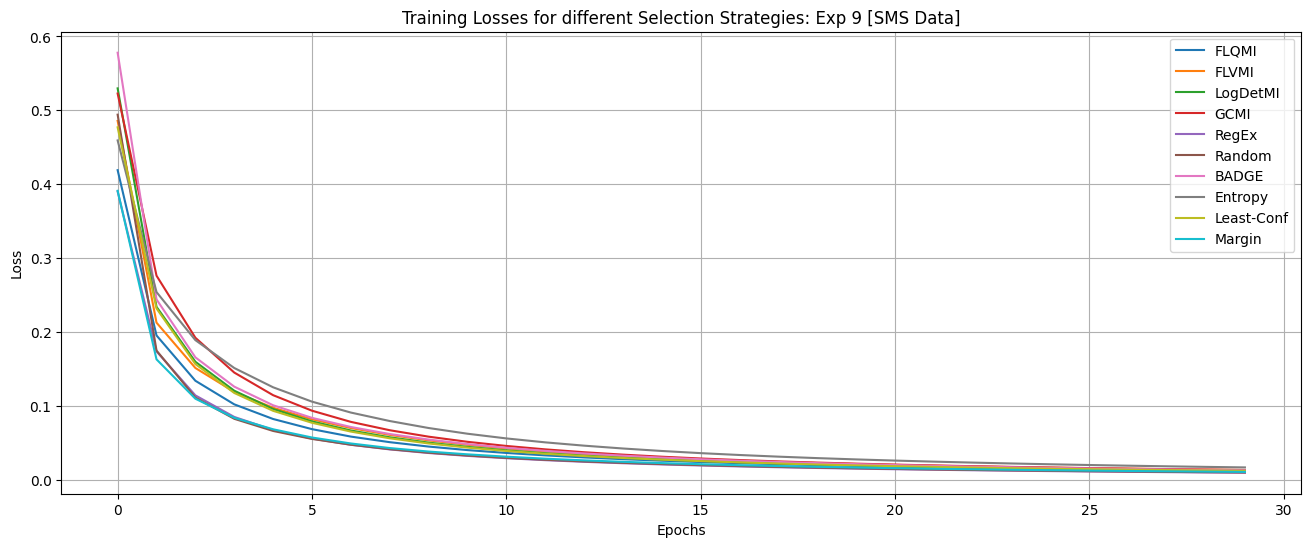

In [ ]:
plot_multiple_losses({
    'FLQMI': losses_fl2mi, 'FLVMI': losses_fl1mi,
    'LogDetMI': losses_logdetmi, 'GCMI': losses_gcmi,
    'RegEx': losses_regex, 'Random': losses_random,
    'BADGE': losses_badge, 'Entropy': losses_entropy,
    'Least-Conf': losses_leastconf, 'Margin': losses_margin,
    'KMeans': losses_kmeans
})

## Metric Compilation

In [ ]:
metric_list = [fl2mi_metrics, fl1mi_metrics, logdetmi_metrics, gcmi_metrics,
               regex_metrics, random_metrics, badge_metrics, entropy_metrics,
               leastconf_metrics, margin_metrics, kmeans_metrics]

In [ ]:
metrics_compiled = {k: {
    metric['name']: metric[k] for metric in metric_list
    } for k in metric_list[0] if (k!='name')}
metrics_compiled

{'tp': {'FLQMI': 167,
  'FLVMI': 237,
  'LogDetMI': 214,
  'GCMI': 408,
  'RegEx': 80,
  'Random': 4,
  'BADGE': 195,
  'Entropy': 203,
  'Least_Conf': 295,
  'Margin': 3},
 'fp': {'FLQMI': 3,
  'FLVMI': 3,
  'LogDetMI': 1,
  'GCMI': 58,
  'RegEx': 0,
  'Random': 0,
  'BADGE': 1,
  'Entropy': 1,
  'Least_Conf': 5,
  'Margin': 0},
 'fn': {'FLQMI': 309,
  'FLVMI': 239,
  'LogDetMI': 262,
  'GCMI': 68,
  'RegEx': 396,
  'Random': 472,
  'BADGE': 281,
  'Entropy': 273,
  'Least_Conf': 181,
  'Margin': 473},
 'tn': {'FLQMI': 476,
  'FLVMI': 476,
  'LogDetMI': 478,
  'GCMI': 421,
  'RegEx': 479,
  'Random': 479,
  'BADGE': 478,
  'Entropy': 478,
  'Least_Conf': 474,
  'Margin': 479},
 'acc': {'FLQMI': 0.6732984293193718,
  'FLVMI': 0.7465968586387435,
  'LogDetMI': 0.724607329842932,
  'GCMI': 0.8680628272251308,
  'RegEx': 0.5853403141361256,
  'Random': 0.5057591623036649,
  'BADGE': 0.7047120418848167,
  'Entropy': 0.7130890052356021,
  'Least_Conf': 0.8052356020942408,
  'Margin': 0.5047

In [ ]:
with open('logs.txt', 'a') as tf:
    tf.write('\n\nExp{}_metrics'.format(exp_num))
    tf.write(' = {')
    for k in metric_list[0]:
        if (k!='name'):
            tf.write("'{}': ".format(k))
            tf.write('{')
            for metric in metric_list[:-1]:
                tf.write("'{}': {}, ".format(metric['name'], round(metric[k], 5)))
            tf.write("'{}': {}".format(metric_list[-1]['name'], round(metric_list[-1][k], 5)))
            tf.write('}, ')

with open('logs.txt', 'r') as tf:
    contents = tf.read()
contents = contents[:-2]
with open('logs.txt', 'w') as tf:
    tf.write(contents)
    tf.write('}')


NOTE: Execute only till here for each experimental run. After each run, copy metrics generated in above output cell or output txt file and paste in the below cell for the respective experiment. After completing all 10 experiments, run below cells only by uncommenting to generate mean metrics and performance graphs.

## Overall Metric Stats

In [ ]:
def get_stats(values):
    return {'range': (min(values), max(values)), 'avg': round(sum(values)/len(values), 5), 'std_dev': round(stat.stdev(values), 5)}

In [ ]:
def end_of_exp():
    Exp1_metrics = {'tp': {'FLQMI': 13, 'FLVMI': 24, 'LogDetMI': 284, 'GCMI': 419, 'RegEx': 17, 'Random': 12, 'BADGE': 84, 'Entropy': 7, 'Least_Conf': 54, 'Margin': 345}, 'fp': {'FLQMI': 2, 'FLVMI': 0, 'LogDetMI': 4, 'GCMI': 55, 'RegEx': 0, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 10}, 'fn': {'FLQMI': 463, 'FLVMI': 452, 'LogDetMI': 192, 'GCMI': 57, 'RegEx': 459, 'Random': 464, 'BADGE': 392, 'Entropy': 469, 'Least_Conf': 422, 'Margin': 131}, 'tn': {'FLQMI': 478, 'FLVMI': 480, 'LogDetMI': 476, 'GCMI': 425, 'RegEx': 480, 'Random': 480, 'BADGE': 480, 'Entropy': 480, 'Least_Conf': 480, 'Margin': 470}, 'acc': {'FLQMI': 0.5136, 'FLVMI': 0.5272, 'LogDetMI': 0.79498, 'GCMI': 0.88285, 'RegEx': 0.51987, 'Random': 0.51464, 'BADGE': 0.58996, 'Entropy': 0.50941, 'Least_Conf': 0.55858, 'Margin': 0.85251}, 'f1': {'FLQMI': 0.05295, 'FLVMI': 0.096, 'LogDetMI': 0.74346, 'GCMI': 0.88211, 'RegEx': 0.06897, 'Random': 0.04918, 'BADGE': 0.3, 'Entropy': 0.02899, 'Least_Conf': 0.20377, 'Margin': 0.83032}, 'ppv': {'FLQMI': 0.86667, 'FLVMI': 1.0, 'LogDetMI': 0.98611, 'GCMI': 0.88397, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.97183}, 'tpr': {'FLQMI': 0.02731, 'FLVMI': 0.05042, 'LogDetMI': 0.59664, 'GCMI': 0.88025, 'RegEx': 0.03571, 'Random': 0.02521, 'BADGE': 0.17647, 'Entropy': 0.01471, 'Least_Conf': 0.11345, 'Margin': 0.72479}, 'fpr': {'FLQMI': 0.00417, 'FLVMI': 0.0, 'LogDetMI': 0.00833, 'GCMI': 0.11458, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.02083}, 'fnr': {'FLQMI': 0.97269, 'FLVMI': 0.94958, 'LogDetMI': 0.40336, 'GCMI': 0.11975, 'RegEx': 0.96429, 'Random': 0.97479, 'BADGE': 0.82353, 'Entropy': 0.98529, 'Least_Conf': 0.88655, 'Margin': 0.27521}, 'tnr': {'FLQMI': 0.99583, 'FLVMI': 1.0, 'LogDetMI': 0.99167, 'GCMI': 0.88542, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.97917}, 'npv': {'FLQMI': 0.50797, 'FLVMI': 0.51502, 'LogDetMI': 0.71257, 'GCMI': 0.88174, 'RegEx': 0.51118, 'Random': 0.50847, 'BADGE': 0.55046, 'Entropy': 0.5058, 'Least_Conf': 0.53215, 'Margin': 0.78203}, 'fdr': {'FLQMI': 0.13333, 'FLVMI': 0.0, 'LogDetMI': 0.01389, 'GCMI': 0.11603, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.02817}, 'mcc': {'FLQMI': 0.09312, 'FLVMI': 0.16114, 'LogDetMI': 0.64112, 'GCMI': 0.76569, 'RegEx': 0.13512, 'Random': 0.11322, 'BADGE': 0.31167, 'Entropy': 0.08624, 'Least_Conf': 0.2457, 'Margin': 0.72848}}
    Exp2_metrics = {'tp': {'FLQMI': 189, 'FLVMI': 236, 'LogDetMI': 240, 'GCMI': 430, 'RegEx': 230, 'Random': 26, 'BADGE': 96, 'Entropy': 214, 'Least_Conf': 1, 'Margin': 6}, 'fp': {'FLQMI': 1, 'FLVMI': 3, 'LogDetMI': 4, 'GCMI': 101, 'RegEx': 1, 'Random': 0, 'BADGE': 0, 'Entropy': 2, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 287, 'FLVMI': 240, 'LogDetMI': 236, 'GCMI': 46, 'RegEx': 246, 'Random': 450, 'BADGE': 380, 'Entropy': 262, 'Least_Conf': 475, 'Margin': 470}, 'tn': {'FLQMI': 478, 'FLVMI': 476, 'LogDetMI': 475, 'GCMI': 378, 'RegEx': 478, 'Random': 479, 'BADGE': 479, 'Entropy': 477, 'Least_Conf': 479, 'Margin': 479}, 'acc': {'FLQMI': 0.69843, 'FLVMI': 0.74555, 'LogDetMI': 0.74869, 'GCMI': 0.84607, 'RegEx': 0.74136, 'Random': 0.5288, 'BADGE': 0.60209, 'Entropy': 0.72356, 'Least_Conf': 0.50262, 'Margin': 0.50785}, 'f1': {'FLQMI': 0.56757, 'FLVMI': 0.66014, 'LogDetMI': 0.66667, 'GCMI': 0.85402, 'RegEx': 0.65064, 'Random': 0.10359, 'BADGE': 0.33566, 'Entropy': 0.6185, 'Least_Conf': 0.00419, 'Margin': 0.0249}, 'ppv': {'FLQMI': 0.99474, 'FLVMI': 0.98745, 'LogDetMI': 0.98361, 'GCMI': 0.80979, 'RegEx': 0.99567, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0.99074, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.39706, 'FLVMI': 0.4958, 'LogDetMI': 0.5042, 'GCMI': 0.90336, 'RegEx': 0.48319, 'Random': 0.05462, 'BADGE': 0.20168, 'Entropy': 0.44958, 'Least_Conf': 0.0021, 'Margin': 0.01261}, 'fpr': {'FLQMI': 0.00209, 'FLVMI': 0.00626, 'LogDetMI': 0.00835, 'GCMI': 0.21086, 'RegEx': 0.00209, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.00418, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.60294, 'FLVMI': 0.5042, 'LogDetMI': 0.4958, 'GCMI': 0.09664, 'RegEx': 0.51681, 'Random': 0.94538, 'BADGE': 0.79832, 'Entropy': 0.55042, 'Least_Conf': 0.9979, 'Margin': 0.98739}, 'tnr': {'FLQMI': 0.99791, 'FLVMI': 0.99374, 'LogDetMI': 0.99165, 'GCMI': 0.78914, 'RegEx': 0.99791, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0.99582, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.62484, 'FLVMI': 0.6648, 'LogDetMI': 0.66807, 'GCMI': 0.89151, 'RegEx': 0.66022, 'Random': 0.51561, 'BADGE': 0.55763, 'Entropy': 0.64547, 'Least_Conf': 0.5021, 'Margin': 0.50474}, 'fdr': {'FLQMI': 0.00526, 'FLVMI': 0.01255, 'LogDetMI': 0.01639, 'GCMI': 0.19021, 'RegEx': 0.00433, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.00926, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.49469, 'FLVMI': 0.56507, 'LogDetMI': 0.56845, 'GCMI': 0.69689, 'RegEx': 0.56174, 'Random': 0.16782, 'BADGE': 0.33535, 'Entropy': 0.53232, 'Least_Conf': 0.03248, 'Margin': 0.07976}}
    Exp3_metrics = {'tp': {'FLQMI': 63, 'FLVMI': 154, 'LogDetMI': 214, 'GCMI': 398, 'RegEx': 238, 'Random': 4, 'BADGE': 166, 'Entropy': 153, 'Least_Conf': 0, 'Margin': 178}, 'fp': {'FLQMI': 0, 'FLVMI': 0, 'LogDetMI': 1, 'GCMI': 80, 'RegEx': 4, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 1}, 'fn': {'FLQMI': 413, 'FLVMI': 322, 'LogDetMI': 262, 'GCMI': 78, 'RegEx': 238, 'Random': 472, 'BADGE': 310, 'Entropy': 323, 'Least_Conf': 476, 'Margin': 298}, 'tn': {'FLQMI': 479, 'FLVMI': 479, 'LogDetMI': 478, 'GCMI': 399, 'RegEx': 475, 'Random': 479, 'BADGE': 479, 'Entropy': 479, 'Least_Conf': 479, 'Margin': 478}, 'acc': {'FLQMI': 0.56754, 'FLVMI': 0.66283, 'LogDetMI': 0.72461, 'GCMI': 0.83455, 'RegEx': 0.7466, 'Random': 0.50576, 'BADGE': 0.67539, 'Entropy': 0.66178, 'Least_Conf': 0.50157, 'Margin': 0.68691}, 'f1': {'FLQMI': 0.23377, 'FLVMI': 0.48889, 'LogDetMI': 0.61939, 'GCMI': 0.83438, 'RegEx': 0.66295, 'Random': 0.01667, 'BADGE': 0.51713, 'Entropy': 0.48649, 'Least_Conf': 0.0, 'Margin': 0.54351}, 'ppv': {'FLQMI': 1.0, 'FLVMI': 1.0, 'LogDetMI': 0.99535, 'GCMI': 0.83264, 'RegEx': 0.98347, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 0, 'Margin': 0.99441}, 'tpr': {'FLQMI': 0.13235, 'FLVMI': 0.32353, 'LogDetMI': 0.44958, 'GCMI': 0.83613, 'RegEx': 0.5, 'Random': 0.0084, 'BADGE': 0.34874, 'Entropy': 0.32143, 'Least_Conf': 0.0, 'Margin': 0.37395}, 'fpr': {'FLQMI': 0.0, 'FLVMI': 0.0, 'LogDetMI': 0.00209, 'GCMI': 0.16701, 'RegEx': 0.00835, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.00209}, 'fnr': {'FLQMI': 0.86765, 'FLVMI': 0.67647, 'LogDetMI': 0.55042, 'GCMI': 0.16387, 'RegEx': 0.5, 'Random': 0.9916, 'BADGE': 0.65126, 'Entropy': 0.67857, 'Least_Conf': 1.0, 'Margin': 0.62605}, 'tnr': {'FLQMI': 1.0, 'FLVMI': 1.0, 'LogDetMI': 0.99791, 'GCMI': 0.83299, 'RegEx': 0.99165, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.99791}, 'npv': {'FLQMI': 0.537, 'FLVMI': 0.598, 'LogDetMI': 0.64595, 'GCMI': 0.83648, 'RegEx': 0.6662, 'Random': 0.50368, 'BADGE': 0.6071, 'Entropy': 0.59726, 'Least_Conf': 0.50157, 'Margin': 0.61598}, 'fdr': {'FLQMI': 0.0, 'FLVMI': 0.0, 'LogDetMI': 0.00465, 'GCMI': 0.16736, 'RegEx': 0.01653, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0, 'Margin': 0.00559}, 'mcc': {'FLQMI': 0.2666, 'FLVMI': 0.43985, 'LogDetMI': 0.5357, 'GCMI': 0.66912, 'RegEx': 0.56516, 'Random': 0.06506, 'BADGE': 0.46013, 'Entropy': 0.43815, 'Least_Conf': 0, 'Margin': 0.47643}}
    Exp4_metrics = {'tp': {'FLQMI': 12, 'FLVMI': 53, 'LogDetMI': 143, 'GCMI': 394, 'RegEx': 48, 'Random': 4, 'BADGE': 40, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 374}, 'fp': {'FLQMI': 0, 'FLVMI': 0, 'LogDetMI': 0, 'GCMI': 54, 'RegEx': 0, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 4}, 'fn': {'FLQMI': 464, 'FLVMI': 423, 'LogDetMI': 333, 'GCMI': 82, 'RegEx': 428, 'Random': 472, 'BADGE': 436, 'Entropy': 476, 'Least_Conf': 476, 'Margin': 102}, 'tn': {'FLQMI': 479, 'FLVMI': 479, 'LogDetMI': 479, 'GCMI': 425, 'RegEx': 479, 'Random': 479, 'BADGE': 479, 'Entropy': 479, 'Least_Conf': 479, 'Margin': 475}, 'acc': {'FLQMI': 0.51414, 'FLVMI': 0.55707, 'LogDetMI': 0.65131, 'GCMI': 0.85759, 'RegEx': 0.55183, 'Random': 0.50576, 'BADGE': 0.54346, 'Entropy': 0.50157, 'Least_Conf': 0.50157, 'Margin': 0.88901}, 'f1': {'FLQMI': 0.04918, 'FLVMI': 0.20038, 'LogDetMI': 0.46204, 'GCMI': 0.85281, 'RegEx': 0.18321, 'Random': 0.01667, 'BADGE': 0.15504, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.87588}, 'ppv': {'FLQMI': 1.0, 'FLVMI': 1.0, 'LogDetMI': 1.0, 'GCMI': 0.87946, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0.98942}, 'tpr': {'FLQMI': 0.02521, 'FLVMI': 0.11134, 'LogDetMI': 0.30042, 'GCMI': 0.82773, 'RegEx': 0.10084, 'Random': 0.0084, 'BADGE': 0.08403, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.78571}, 'fpr': {'FLQMI': 0.0, 'FLVMI': 0.0, 'LogDetMI': 0.0, 'GCMI': 0.11273, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.00835}, 'fnr': {'FLQMI': 0.97479, 'FLVMI': 0.88866, 'LogDetMI': 0.69958, 'GCMI': 0.17227, 'RegEx': 0.89916, 'Random': 0.9916, 'BADGE': 0.91597, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.21429}, 'tnr': {'FLQMI': 1.0, 'FLVMI': 1.0, 'LogDetMI': 1.0, 'GCMI': 0.88727, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.99165}, 'npv': {'FLQMI': 0.50795, 'FLVMI': 0.53104, 'LogDetMI': 0.5899, 'GCMI': 0.83826, 'RegEx': 0.52811, 'Random': 0.50368, 'BADGE': 0.5235, 'Entropy': 0.50157, 'Least_Conf': 0.50157, 'Margin': 0.82322}, 'fdr': {'FLQMI': 0.0, 'FLVMI': 0.0, 'LogDetMI': 0.0, 'GCMI': 0.12054, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0.01058}, 'mcc': {'FLQMI': 0.11316, 'FLVMI': 0.24316, 'LogDetMI': 0.42097, 'GCMI': 0.71636, 'RegEx': 0.23077, 'Random': 0.06506, 'BADGE': 0.20974, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0.79481}}
    Exp5_metrics = {'tp': {'FLQMI': 80, 'FLVMI': 155, 'LogDetMI': 134, 'GCMI': 416, 'RegEx': 18, 'Random': 244, 'BADGE': 9, 'Entropy': 320, 'Least_Conf': 59, 'Margin': 1}, 'fp': {'FLQMI': 1, 'FLVMI': 0, 'LogDetMI': 0, 'GCMI': 36, 'RegEx': 0, 'Random': 5, 'BADGE': 0, 'Entropy': 30, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 396, 'FLVMI': 321, 'LogDetMI': 342, 'GCMI': 60, 'RegEx': 458, 'Random': 232, 'BADGE': 467, 'Entropy': 156, 'Least_Conf': 417, 'Margin': 475}, 'tn': {'FLQMI': 479, 'FLVMI': 480, 'LogDetMI': 480, 'GCMI': 444, 'RegEx': 480, 'Random': 475, 'BADGE': 480, 'Entropy': 450, 'Least_Conf': 480, 'Margin': 480}, 'acc': {'FLQMI': 0.58473, 'FLVMI': 0.66423, 'LogDetMI': 0.64226, 'GCMI': 0.89958, 'RegEx': 0.52092, 'Random': 0.75209, 'BADGE': 0.51151, 'Entropy': 0.80544, 'Least_Conf': 0.56381, 'Margin': 0.50314}, 'f1': {'FLQMI': 0.28725, 'FLVMI': 0.49128, 'LogDetMI': 0.43934, 'GCMI': 0.89655, 'RegEx': 0.07287, 'Random': 0.6731, 'BADGE': 0.03711, 'Entropy': 0.77482, 'Least_Conf': 0.22056, 'Margin': 0.00419}, 'ppv': {'FLQMI': 0.98765, 'FLVMI': 1.0, 'LogDetMI': 1.0, 'GCMI': 0.92035, 'RegEx': 1.0, 'Random': 0.97992, 'BADGE': 1.0, 'Entropy': 0.91429, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.16807, 'FLVMI': 0.32563, 'LogDetMI': 0.28151, 'GCMI': 0.87395, 'RegEx': 0.03782, 'Random': 0.51261, 'BADGE': 0.01891, 'Entropy': 0.67227, 'Least_Conf': 0.12395, 'Margin': 0.0021}, 'fpr': {'FLQMI': 0.00208, 'FLVMI': 0.0, 'LogDetMI': 0.0, 'GCMI': 0.075, 'RegEx': 0.0, 'Random': 0.01042, 'BADGE': 0.0, 'Entropy': 0.0625, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.83193, 'FLVMI': 0.67437, 'LogDetMI': 0.71849, 'GCMI': 0.12605, 'RegEx': 0.96218, 'Random': 0.48739, 'BADGE': 0.98109, 'Entropy': 0.32773, 'Least_Conf': 0.87605, 'Margin': 0.9979}, 'tnr': {'FLQMI': 0.99792, 'FLVMI': 1.0, 'LogDetMI': 1.0, 'GCMI': 0.925, 'RegEx': 1.0, 'Random': 0.98958, 'BADGE': 1.0, 'Entropy': 0.9375, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.54743, 'FLVMI': 0.59925, 'LogDetMI': 0.58394, 'GCMI': 0.88095, 'RegEx': 0.51173, 'Random': 0.67185, 'BADGE': 0.50686, 'Entropy': 0.74257, 'Least_Conf': 0.53512, 'Margin': 0.50262}, 'fdr': {'FLQMI': 0.01235, 'FLVMI': 0.0, 'LogDetMI': 0.0, 'GCMI': 0.07965, 'RegEx': 0.0, 'Random': 0.02008, 'BADGE': 0.0, 'Entropy': 0.08571, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.29802, 'FLVMI': 0.44174, 'LogDetMI': 0.40545, 'GCMI': 0.80013, 'RegEx': 0.13911, 'Random': 0.57211, 'BADGE': 0.0979, 'Entropy': 0.63288, 'Least_Conf': 0.25754, 'Margin': 0.03249}}
    Exp6_metrics = {'tp': {'FLQMI': 34, 'FLVMI': 303, 'LogDetMI': 277, 'GCMI': 410, 'RegEx': 188, 'Random': 14, 'BADGE': 91, 'Entropy': 6, 'Least_Conf': 10, 'Margin': 0}, 'fp': {'FLQMI': 0, 'FLVMI': 2, 'LogDetMI': 7, 'GCMI': 81, 'RegEx': 1, 'Random': 0, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 442, 'FLVMI': 173, 'LogDetMI': 199, 'GCMI': 66, 'RegEx': 288, 'Random': 462, 'BADGE': 385, 'Entropy': 470, 'Least_Conf': 466, 'Margin': 476}, 'tn': {'FLQMI': 479, 'FLVMI': 477, 'LogDetMI': 472, 'GCMI': 398, 'RegEx': 478, 'Random': 479, 'BADGE': 479, 'Entropy': 479, 'Least_Conf': 479, 'Margin': 479}, 'acc': {'FLQMI': 0.53717, 'FLVMI': 0.81675, 'LogDetMI': 0.78429, 'GCMI': 0.84607, 'RegEx': 0.69738, 'Random': 0.51623, 'BADGE': 0.59686, 'Entropy': 0.50785, 'Least_Conf': 0.51204, 'Margin': 0.50157}, 'f1': {'FLQMI': 0.13333, 'FLVMI': 0.77593, 'LogDetMI': 0.72895, 'GCMI': 0.84798, 'RegEx': 0.56541, 'Random': 0.05714, 'BADGE': 0.32099, 'Entropy': 0.0249, 'Least_Conf': 0.04115, 'Margin': 0.0}, 'ppv': {'FLQMI': 1.0, 'FLVMI': 0.99344, 'LogDetMI': 0.97535, 'GCMI': 0.83503, 'RegEx': 0.99471, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0}, 'tpr': {'FLQMI': 0.07143, 'FLVMI': 0.63655, 'LogDetMI': 0.58193, 'GCMI': 0.86134, 'RegEx': 0.39496, 'Random': 0.02941, 'BADGE': 0.19118, 'Entropy': 0.01261, 'Least_Conf': 0.02101, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.0, 'FLVMI': 0.00418, 'LogDetMI': 0.01461, 'GCMI': 0.1691, 'RegEx': 0.00209, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.92857, 'FLVMI': 0.36345, 'LogDetMI': 0.41807, 'GCMI': 0.13866, 'RegEx': 0.60504, 'Random': 0.97059, 'BADGE': 0.80882, 'Entropy': 0.98739, 'Least_Conf': 0.97899, 'Margin': 1.0}, 'tnr': {'FLQMI': 1.0, 'FLVMI': 0.99582, 'LogDetMI': 0.98539, 'GCMI': 0.8309, 'RegEx': 0.99791, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.52009, 'FLVMI': 0.73385, 'LogDetMI': 0.70343, 'GCMI': 0.85776, 'RegEx': 0.62402, 'Random': 0.50903, 'BADGE': 0.5544, 'Entropy': 0.50474, 'Least_Conf': 0.50688, 'Margin': 0.50157}, 'fdr': {'FLQMI': 0.0, 'FLVMI': 0.00656, 'LogDetMI': 0.02465, 'GCMI': 0.16497, 'RegEx': 0.00529, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0}, 'mcc': {'FLQMI': 0.19274, 'FLVMI': 0.67818, 'LogDetMI': 0.62055, 'GCMI': 0.69252, 'RegEx': 0.49303, 'Random': 0.12236, 'BADGE': 0.32556, 'Entropy': 0.07976, 'Least_Conf': 0.10319, 'Margin': 0}}
    Exp7_metrics = {'tp': {'FLQMI': 122, 'FLVMI': 68, 'LogDetMI': 190, 'GCMI': 429, 'RegEx': 310, 'Random': 70, 'BADGE': 20, 'Entropy': 358, 'Least_Conf': 4, 'Margin': 62}, 'fp': {'FLQMI': 2, 'FLVMI': 1, 'LogDetMI': 0, 'GCMI': 74, 'RegEx': 1, 'Random': 0, 'BADGE': 0, 'Entropy': 3, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 354, 'FLVMI': 408, 'LogDetMI': 286, 'GCMI': 47, 'RegEx': 166, 'Random': 406, 'BADGE': 456, 'Entropy': 118, 'Least_Conf': 472, 'Margin': 414}, 'tn': {'FLQMI': 478, 'FLVMI': 479, 'LogDetMI': 480, 'GCMI': 406, 'RegEx': 479, 'Random': 480, 'BADGE': 480, 'Entropy': 477, 'Least_Conf': 480, 'Margin': 480}, 'acc': {'FLQMI': 0.62762, 'FLVMI': 0.57218, 'LogDetMI': 0.70084, 'GCMI': 0.87343, 'RegEx': 0.82531, 'Random': 0.57531, 'BADGE': 0.52301, 'Entropy': 0.87343, 'Least_Conf': 0.50628, 'Margin': 0.56695}, 'f1': {'FLQMI': 0.40667, 'FLVMI': 0.24954, 'LogDetMI': 0.57057, 'GCMI': 0.8764, 'RegEx': 0.7878, 'Random': 0.25641, 'BADGE': 0.08065, 'Entropy': 0.85544, 'Least_Conf': 0.01667, 'Margin': 0.23048}, 'ppv': {'FLQMI': 0.98387, 'FLVMI': 0.98551, 'LogDetMI': 1.0, 'GCMI': 0.85288, 'RegEx': 0.99678, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0.99169, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.2563, 'FLVMI': 0.14286, 'LogDetMI': 0.39916, 'GCMI': 0.90126, 'RegEx': 0.65126, 'Random': 0.14706, 'BADGE': 0.04202, 'Entropy': 0.7521, 'Least_Conf': 0.0084, 'Margin': 0.13025}, 'fpr': {'FLQMI': 0.00417, 'FLVMI': 0.00208, 'LogDetMI': 0.0, 'GCMI': 0.15417, 'RegEx': 0.00208, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.00625, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.7437, 'FLVMI': 0.85714, 'LogDetMI': 0.60084, 'GCMI': 0.09874, 'RegEx': 0.34874, 'Random': 0.85294, 'BADGE': 0.95798, 'Entropy': 0.2479, 'Least_Conf': 0.9916, 'Margin': 0.86975}, 'tnr': {'FLQMI': 0.99583, 'FLVMI': 0.99792, 'LogDetMI': 1.0, 'GCMI': 0.84583, 'RegEx': 0.99792, 'Random': 1.0, 'BADGE': 1.0, 'Entropy': 0.99375, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.57452, 'FLVMI': 0.54002, 'LogDetMI': 0.62663, 'GCMI': 0.89625, 'RegEx': 0.74264, 'Random': 0.54176, 'BADGE': 0.51282, 'Entropy': 0.80168, 'Least_Conf': 0.5042, 'Margin': 0.53691}, 'fdr': {'FLQMI': 0.01613, 'FLVMI': 0.01449, 'LogDetMI': 0.0, 'GCMI': 0.14712, 'RegEx': 0.00322, 'Random': 0.0, 'BADGE': 0.0, 'Entropy': 0.00831, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.37522, 'FLVMI': 0.27199, 'LogDetMI': 0.50013, 'GCMI': 0.74811, 'RegEx': 0.69283, 'Random': 0.28226, 'BADGE': 0.14679, 'Entropy': 0.76924, 'Least_Conf': 0.06509, 'Margin': 0.26445}}
    Exp8_metrics = {'tp': {'FLQMI': 140, 'FLVMI': 213, 'LogDetMI': 227, 'GCMI': 416, 'RegEx': 10, 'Random': 115, 'BADGE': 118, 'Entropy': 383, 'Least_Conf': 5, 'Margin': 1}, 'fp': {'FLQMI': 1, 'FLVMI': 1, 'LogDetMI': 3, 'GCMI': 50, 'RegEx': 0, 'Random': 0, 'BADGE': 2, 'Entropy': 10, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 336, 'FLVMI': 263, 'LogDetMI': 249, 'GCMI': 60, 'RegEx': 466, 'Random': 361, 'BADGE': 358, 'Entropy': 93, 'Least_Conf': 471, 'Margin': 475}, 'tn': {'FLQMI': 478, 'FLVMI': 478, 'LogDetMI': 476, 'GCMI': 429, 'RegEx': 479, 'Random': 479, 'BADGE': 477, 'Entropy': 469, 'Least_Conf': 479, 'Margin': 479}, 'acc': {'FLQMI': 0.64712, 'FLVMI': 0.72356, 'LogDetMI': 0.73613, 'GCMI': 0.88482, 'RegEx': 0.51204, 'Random': 0.62199, 'BADGE': 0.62304, 'Entropy': 0.89215, 'Least_Conf': 0.50681, 'Margin': 0.50262}, 'f1': {'FLQMI': 0.45381, 'FLVMI': 0.61739, 'LogDetMI': 0.64306, 'GCMI': 0.88323, 'RegEx': 0.04115, 'Random': 0.38917, 'BADGE': 0.39597, 'Entropy': 0.88147, 'Least_Conf': 0.02079, 'Margin': 0.00419}, 'ppv': {'FLQMI': 0.99291, 'FLVMI': 0.99533, 'LogDetMI': 0.98696, 'GCMI': 0.8927, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.98333, 'Entropy': 0.97455, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.29412, 'FLVMI': 0.44748, 'LogDetMI': 0.47689, 'GCMI': 0.87395, 'RegEx': 0.02101, 'Random': 0.2416, 'BADGE': 0.2479, 'Entropy': 0.80462, 'Least_Conf': 0.0105, 'Margin': 0.0021}, 'fpr': {'FLQMI': 0.00209, 'FLVMI': 0.00209, 'LogDetMI': 0.00626, 'GCMI': 0.10438, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.00418, 'Entropy': 0.02088, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.70588, 'FLVMI': 0.55252, 'LogDetMI': 0.52311, 'GCMI': 0.12605, 'RegEx': 0.97899, 'Random': 0.7584, 'BADGE': 0.7521, 'Entropy': 0.19538, 'Least_Conf': 0.9895, 'Margin': 0.9979}, 'tnr': {'FLQMI': 0.99791, 'FLVMI': 0.99791, 'LogDetMI': 0.99374, 'GCMI': 0.89562, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.99582, 'Entropy': 0.97912, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.58722, 'FLVMI': 0.64507, 'LogDetMI': 0.65655, 'GCMI': 0.8773, 'RegEx': 0.50688, 'Random': 0.57024, 'BADGE': 0.57126, 'Entropy': 0.83452, 'Least_Conf': 0.50421, 'Margin': 0.5021}, 'fdr': {'FLQMI': 0.00709, 'FLVMI': 0.00467, 'LogDetMI': 0.01304, 'GCMI': 0.1073, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.01667, 'Entropy': 0.02545, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.4116, 'FLVMI': 0.53407, 'LogDetMI': 0.55032, 'GCMI': 0.76978, 'RegEx': 0.10319, 'Random': 0.37117, 'BADGE': 0.36765, 'Entropy': 0.79631, 'Least_Conf': 0.07278, 'Margin': 0.03248}}
    Exp9_metrics = {'tp': {'FLQMI': 167, 'FLVMI': 237, 'LogDetMI': 214, 'GCMI': 408, 'RegEx': 80, 'Random': 4, 'BADGE': 195, 'Entropy': 203, 'Least_Conf': 295, 'Margin': 3}, 'fp': {'FLQMI': 3, 'FLVMI': 3, 'LogDetMI': 1, 'GCMI': 58, 'RegEx': 0, 'Random': 0, 'BADGE': 1, 'Entropy': 1, 'Least_Conf': 5, 'Margin': 0}, 'fn': {'FLQMI': 309, 'FLVMI': 239, 'LogDetMI': 262, 'GCMI': 68, 'RegEx': 396, 'Random': 472, 'BADGE': 281, 'Entropy': 273, 'Least_Conf': 181, 'Margin': 473}, 'tn': {'FLQMI': 476, 'FLVMI': 476, 'LogDetMI': 478, 'GCMI': 421, 'RegEx': 479, 'Random': 479, 'BADGE': 478, 'Entropy': 478, 'Least_Conf': 474, 'Margin': 479}, 'acc': {'FLQMI': 0.6733, 'FLVMI': 0.7466, 'LogDetMI': 0.72461, 'GCMI': 0.86806, 'RegEx': 0.58534, 'Random': 0.50576, 'BADGE': 0.70471, 'Entropy': 0.71309, 'Least_Conf': 0.80524, 'Margin': 0.50471}, 'f1': {'FLQMI': 0.51703, 'FLVMI': 0.66201, 'LogDetMI': 0.61939, 'GCMI': 0.86624, 'RegEx': 0.28777, 'Random': 0.01667, 'BADGE': 0.58036, 'Entropy': 0.59706, 'Least_Conf': 0.76031, 'Margin': 0.01253}, 'ppv': {'FLQMI': 0.98235, 'FLVMI': 0.9875, 'LogDetMI': 0.99535, 'GCMI': 0.87554, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.9949, 'Entropy': 0.9951, 'Least_Conf': 0.98333, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.35084, 'FLVMI': 0.4979, 'LogDetMI': 0.44958, 'GCMI': 0.85714, 'RegEx': 0.16807, 'Random': 0.0084, 'BADGE': 0.40966, 'Entropy': 0.42647, 'Least_Conf': 0.61975, 'Margin': 0.0063}, 'fpr': {'FLQMI': 0.00626, 'FLVMI': 0.00626, 'LogDetMI': 0.00209, 'GCMI': 0.12109, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.00209, 'Entropy': 0.00209, 'Least_Conf': 0.01044, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.64916, 'FLVMI': 0.5021, 'LogDetMI': 0.55042, 'GCMI': 0.14286, 'RegEx': 0.83193, 'Random': 0.9916, 'BADGE': 0.59034, 'Entropy': 0.57353, 'Least_Conf': 0.38025, 'Margin': 0.9937}, 'tnr': {'FLQMI': 0.99374, 'FLVMI': 0.99374, 'LogDetMI': 0.99791, 'GCMI': 0.87891, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.99791, 'Entropy': 0.99791, 'Least_Conf': 0.98956, 'Margin': 1.0}, 'npv': {'FLQMI': 0.60637, 'FLVMI': 0.66573, 'LogDetMI': 0.64595, 'GCMI': 0.86094, 'RegEx': 0.54743, 'Random': 0.50368, 'BADGE': 0.62978, 'Entropy': 0.63648, 'Least_Conf': 0.72366, 'Margin': 0.50315}, 'fdr': {'FLQMI': 0.01765, 'FLVMI': 0.0125, 'LogDetMI': 0.00465, 'GCMI': 0.12446, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.0051, 'Entropy': 0.0049, 'Least_Conf': 0.01667, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.4504, 'FLVMI': 0.5667, 'LogDetMI': 0.5357, 'GCMI': 0.73627, 'RegEx': 0.30332, 'Random': 0.06506, 'BADGE': 0.50458, 'Entropy': 0.51772, 'Least_Conf': 0.65634, 'Margin': 0.05631}}
    Exp10_metrics = {'tp': {'FLQMI': 21, 'FLVMI': 140, 'LogDetMI': 216, 'GCMI': 424, 'RegEx': 4, 'Random': 45, 'BADGE': 183, 'Entropy': 127, 'Least_Conf': 0, 'Margin': 0}, 'fp': {'FLQMI': 0, 'FLVMI': 1, 'LogDetMI': 4, 'GCMI': 43, 'RegEx': 0, 'Random': 0, 'BADGE': 1, 'Entropy': 4, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 455, 'FLVMI': 336, 'LogDetMI': 260, 'GCMI': 52, 'RegEx': 472, 'Random': 431, 'BADGE': 293, 'Entropy': 349, 'Least_Conf': 476, 'Margin': 476}, 'tn': {'FLQMI': 480, 'FLVMI': 479, 'LogDetMI': 476, 'GCMI': 437, 'RegEx': 480, 'Random': 480, 'BADGE': 479, 'Entropy': 476, 'Least_Conf': 480, 'Margin': 480}, 'acc': {'FLQMI': 0.52406, 'FLVMI': 0.64749, 'LogDetMI': 0.72385, 'GCMI': 0.90063, 'RegEx': 0.50628, 'Random': 0.54916, 'BADGE': 0.69247, 'Entropy': 0.63075, 'Least_Conf': 0.50209, 'Margin': 0.50209}, 'f1': {'FLQMI': 0.08451, 'FLVMI': 0.45381, 'LogDetMI': 0.62069, 'GCMI': 0.89926, 'RegEx': 0.01667, 'Random': 0.17274, 'BADGE': 0.55455, 'Entropy': 0.41845, 'Least_Conf': 0.0, 'Margin': 0.0}, 'ppv': {'FLQMI': 1.0, 'FLVMI': 0.99291, 'LogDetMI': 0.98182, 'GCMI': 0.90792, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.99457, 'Entropy': 0.96947, 'Least_Conf': 0, 'Margin': 0}, 'tpr': {'FLQMI': 0.04412, 'FLVMI': 0.29412, 'LogDetMI': 0.45378, 'GCMI': 0.89076, 'RegEx': 0.0084, 'Random': 0.09454, 'BADGE': 0.38445, 'Entropy': 0.26681, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.0, 'FLVMI': 0.00208, 'LogDetMI': 0.00833, 'GCMI': 0.08958, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.00208, 'Entropy': 0.00833, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.95588, 'FLVMI': 0.70588, 'LogDetMI': 0.54622, 'GCMI': 0.10924, 'RegEx': 0.9916, 'Random': 0.90546, 'BADGE': 0.61555, 'Entropy': 0.73319, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tnr': {'FLQMI': 1.0, 'FLVMI': 0.99792, 'LogDetMI': 0.99167, 'GCMI': 0.91042, 'RegEx': 1.0, 'Random': 1.0, 'BADGE': 0.99792, 'Entropy': 0.99167, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.51337, 'FLVMI': 0.58773, 'LogDetMI': 0.64674, 'GCMI': 0.89366, 'RegEx': 0.5042, 'Random': 0.52689, 'BADGE': 0.62047, 'Entropy': 0.57697, 'Least_Conf': 0.50209, 'Margin': 0.50209}, 'fdr': {'FLQMI': 0.0, 'FLVMI': 0.00709, 'LogDetMI': 0.01818, 'GCMI': 0.09208, 'RegEx': 0.0, 'Random': 0.0, 'BADGE': 0.00543, 'Entropy': 0.03053, 'Least_Conf': 0, 'Margin': 0}, 'mcc': {'FLQMI': 0.15049, 'FLVMI': 0.41178, 'LogDetMI': 0.52914, 'GCMI': 0.80138, 'RegEx': 0.06509, 'Random': 0.22318, 'BADGE': 0.48494, 'Entropy': 0.37582, 'Least_Conf': 0, 'Margin': 0}}
    Metric_stats = {k: {
        metric: get_stats([exp[k][metric] for exp in [
            Exp1_metrics, Exp2_metrics, Exp3_metrics, Exp4_metrics, Exp5_metrics,
            Exp6_metrics, Exp7_metrics, Exp8_metrics, Exp9_metrics, Exp10_metrics
            ]]) for metric in Exp1_metrics[k]} for k in Exp1_metrics}
    return Metric_stats

In [ ]:
Metric_stats = end_of_exp()
Metric_stats

{'tp': {'FLQMI': {'range': (12, 189), 'avg': 84.1, 'std_dev': 66.37009},
  'FLVMI': {'range': (24, 303), 'avg': 158.3, 'std_dev': 90.55637},
  'LogDetMI': {'range': (134, 284), 'avg': 213.9, 'std_dev': 49.14254},
  'GCMI': {'range': (394, 430), 'avg': 414.4, 'std_dev': 12.11244},
  'RegEx': {'range': (4, 310), 'avg': 114.3, 'std_dev': 115.36228},
  'Random': {'range': (4, 244), 'avg': 53.8, 'std_dev': 75.86948},
  'BADGE': {'range': (9, 195), 'avg': 100.2, 'std_dev': 66.01986},
  'Entropy': {'range': (0, 383), 'avg': 177.1, 'std_dev': 145.38718},
  'Least_Conf': {'range': (0, 295), 'avg': 42.8, 'std_dev': 91.43644},
  'Margin': {'range': (0, 374), 'avg': 97.0, 'std_dev': 149.21498}},
 'fp': {'FLQMI': {'range': (0, 3), 'avg': 1.0, 'std_dev': 1.05409},
  'FLVMI': {'range': (0, 3), 'avg': 1.1, 'std_dev': 1.19722},
  'LogDetMI': {'range': (0, 7), 'avg': 2.4, 'std_dev': 2.36643},
  'GCMI': {'range': (36, 101), 'avg': 63.2, 'std_dev': 20.12627},
  'RegEx': {'range': (0, 4), 'avg': 0.7, 'std_

## Performance Graphs - Means and Ranges

In [ ]:
def graph_metric(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    min_values = [data[strategy]['range'][0] for strategy in strategies]
    max_values = [data[strategy]['range'][1] for strategy in strategies]
    errors = [np.subtract(averages, min_values), np.subtract(max_values, averages)]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    # using tuple unpacking to grab fig and axes
    fig, ax = plt.subplots(figsize=(16, 6))

    # plotting the bar plot
    plt.plot(strategies, averages, 'o-', color='black', label=strategies)
    # ax.bar(strategies, averages, alpha = 0)

    # Plot error bars
    for i, (strategy, avg) in enumerate(zip(strategies, averages)):
        y_err_lower = errors[0][i]
        y_err_upper = errors[1][i]
        y_err = [[y_err_lower], [y_err_upper]]
        ax.errorbar(strategy, avg, yerr=y_err, fmt='o', lw=2, capsize=4, capthick=2, color=colors[i])

    # Set plot details
    plt.title('Performance comparison of different strategies based on: {} [SMS Data]'.format(metric_dict[metric]))
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with range)')
    plt.show()

### Accuracy Graph

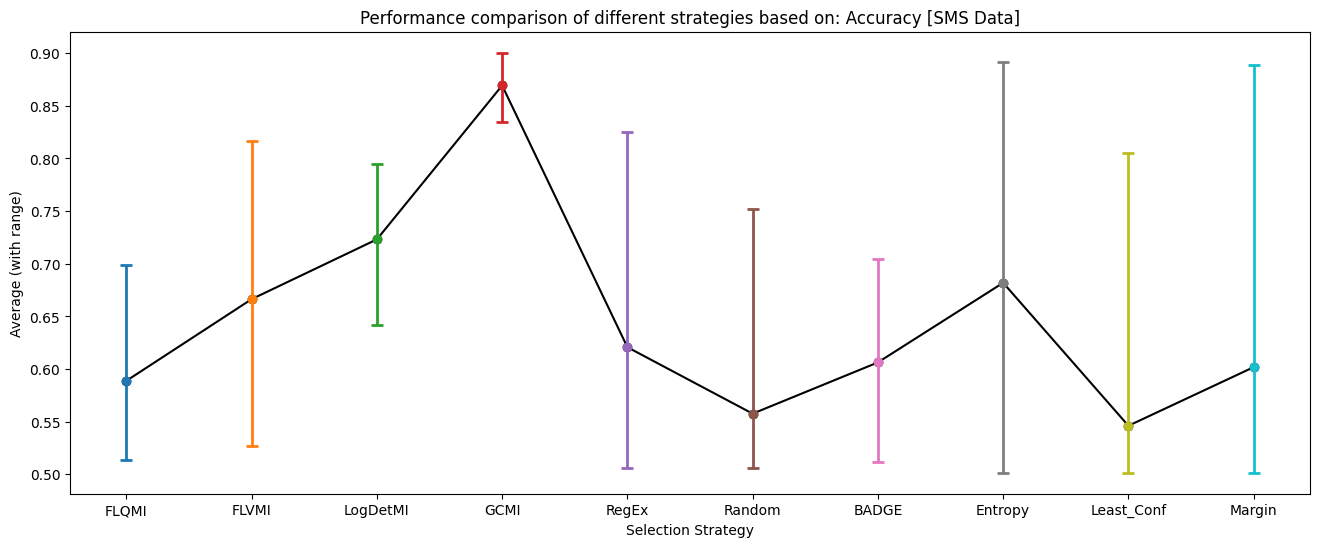

In [ ]:
graph_metric('acc')

### F1-Score Graph

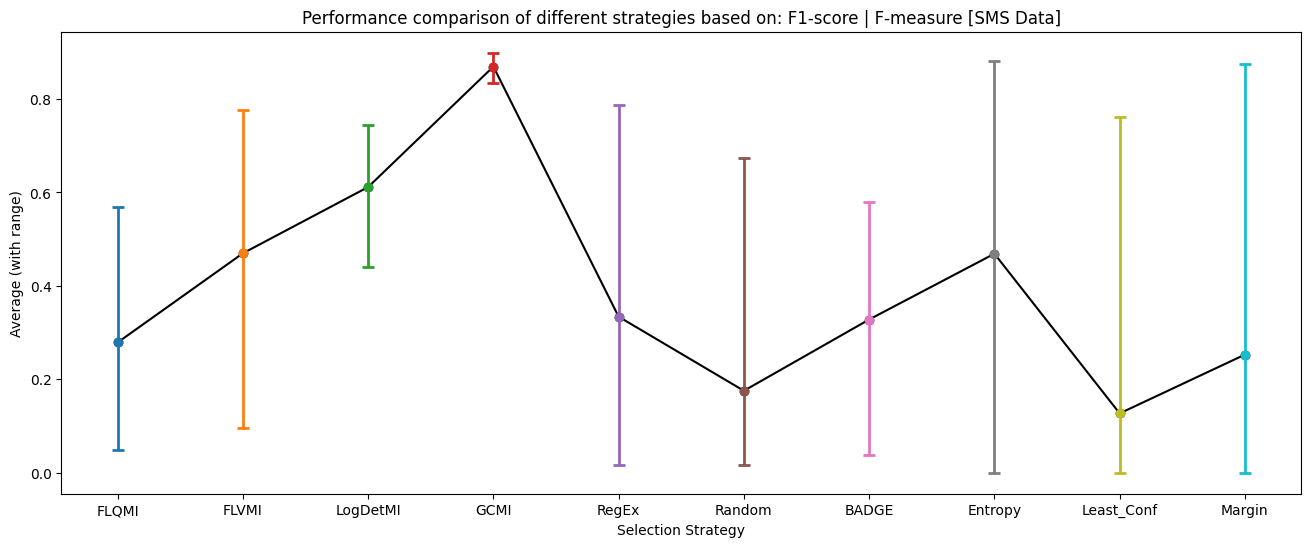

In [ ]:
graph_metric('f1')

### Precision Graph

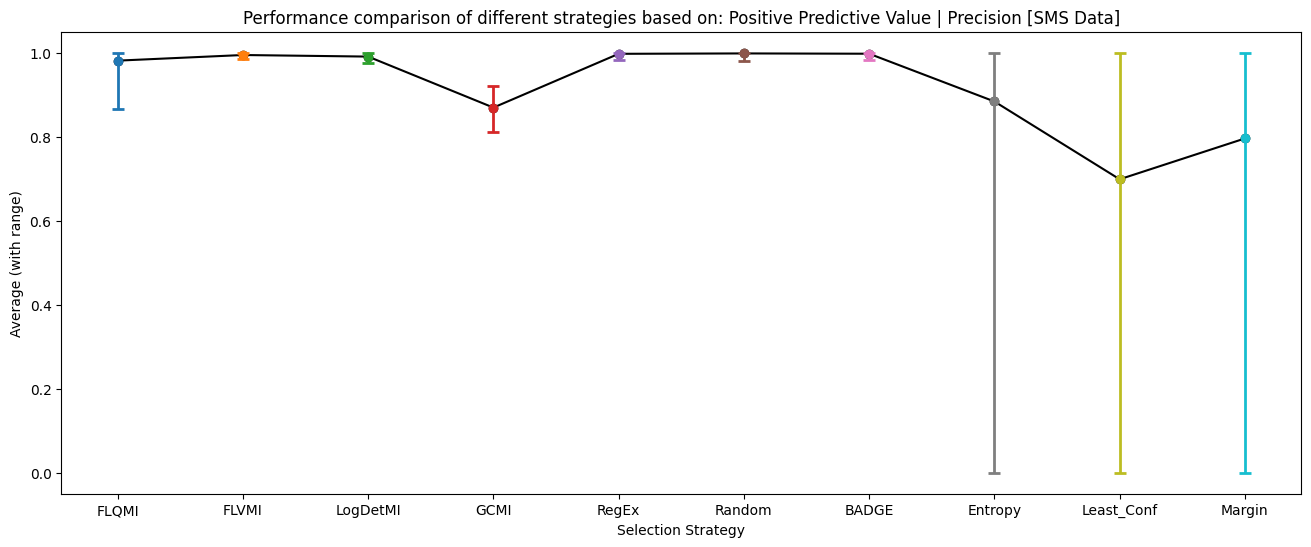

In [ ]:
graph_metric('ppv')

### Recall Graph

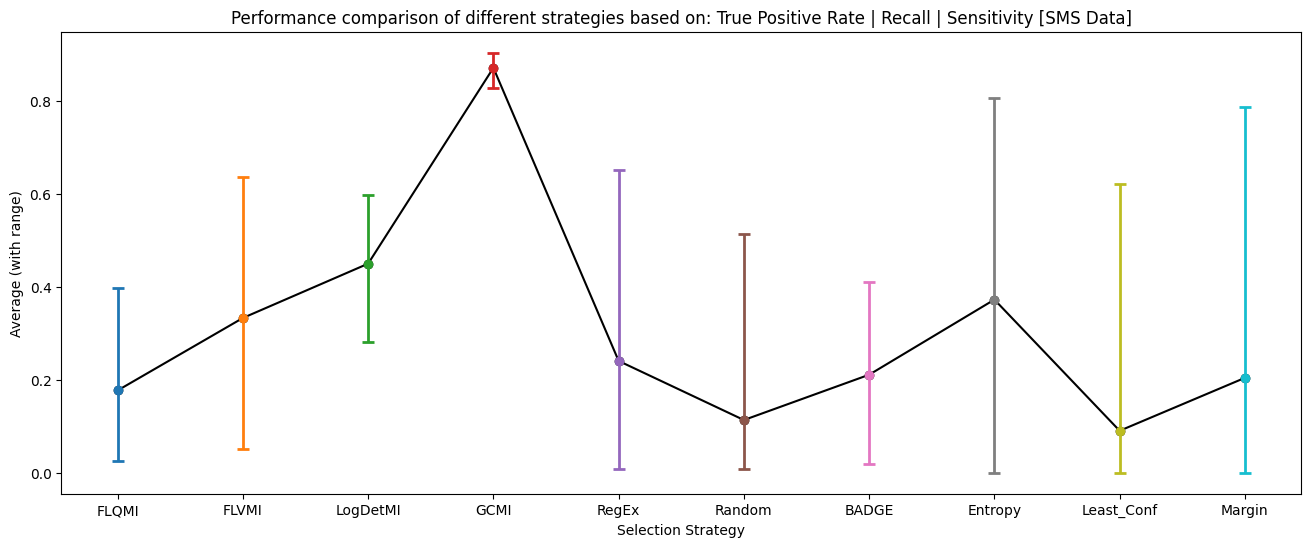

In [ ]:
graph_metric('tpr')

### Matthews Correlation Coefficient Graphs

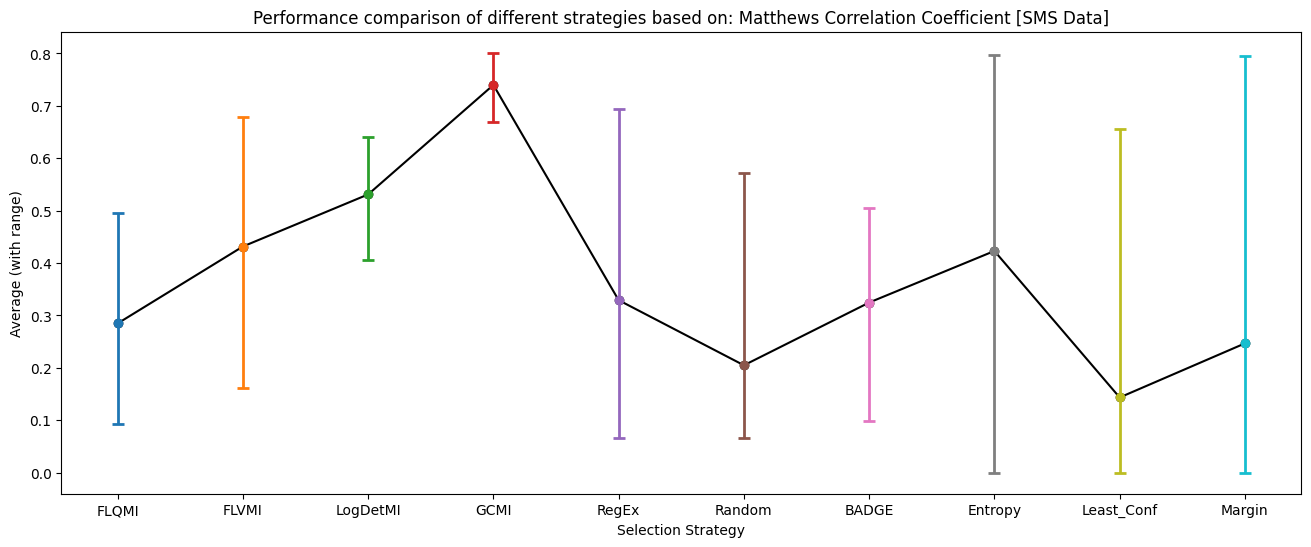

In [ ]:
graph_metric('mcc')

## Performance Graphs - Metric Variations

In [ ]:
def graph_variance(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    std_devs = [data[strategy]['std_dev']/2 for strategy in strategies]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    plt.figure(figsize=(16, 6))
    plt.bar(strategies, averages, yerr=std_devs, alpha = 0.3, capsize=5, color=colors)
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with standard deviation)')
    plt.title('Variation in performance of different strategies based on: {} [SMS Data]'.format(metric_dict[metric]))
    plt.show()

### Accuracy Variation

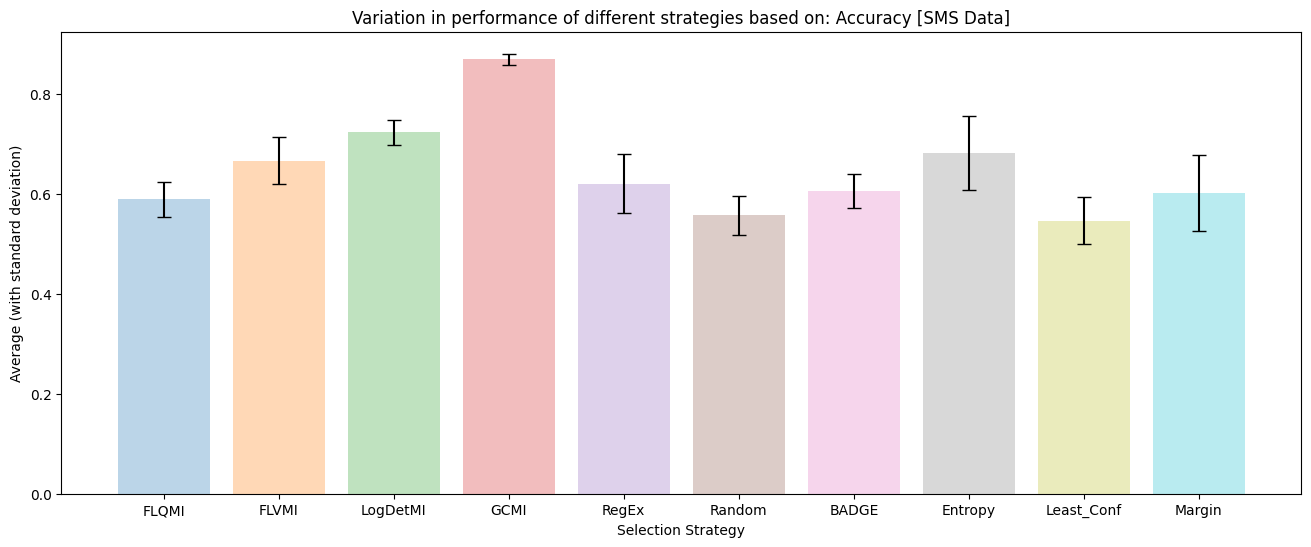

In [ ]:
graph_variance('acc')

### F1-Score Variation

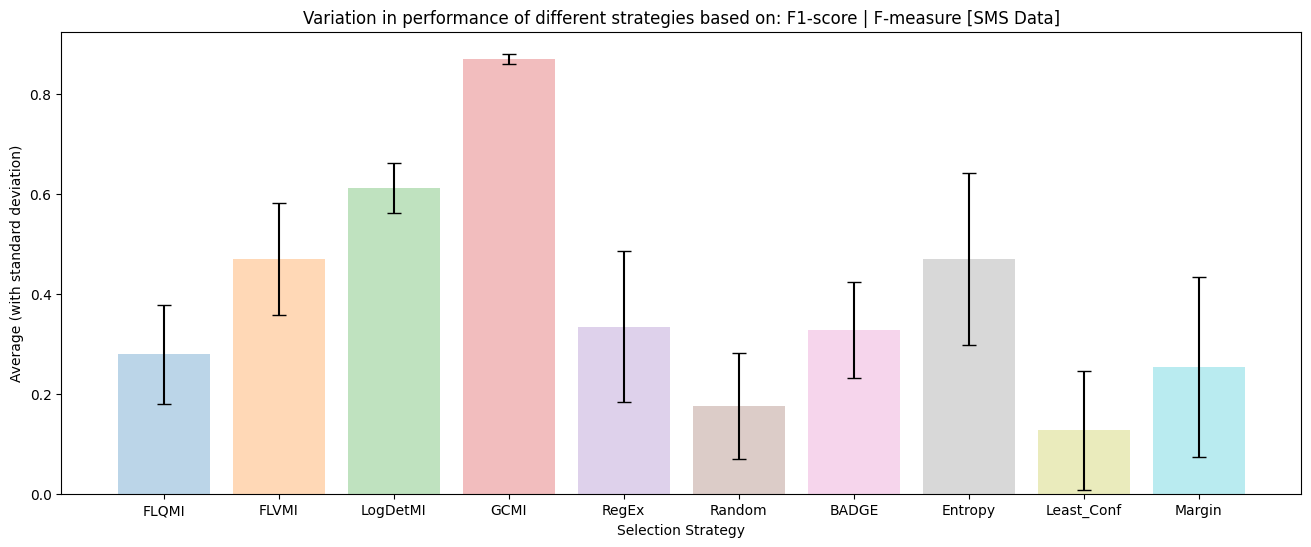

In [ ]:
graph_variance('f1')

### Precision Variation

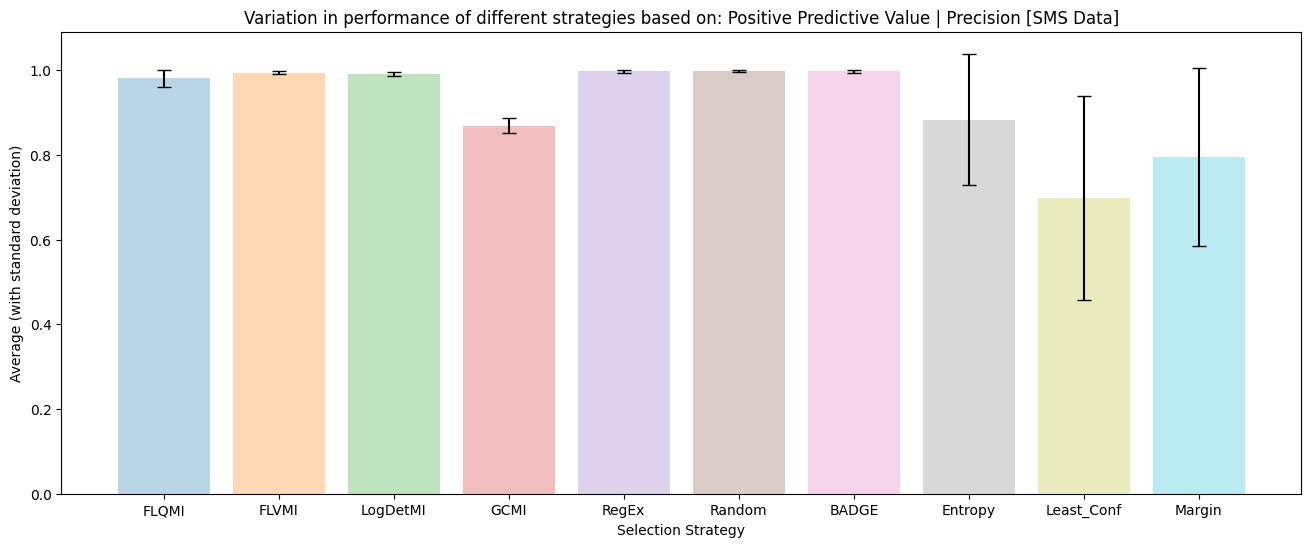

In [ ]:
graph_variance('ppv')

### Recall Variation

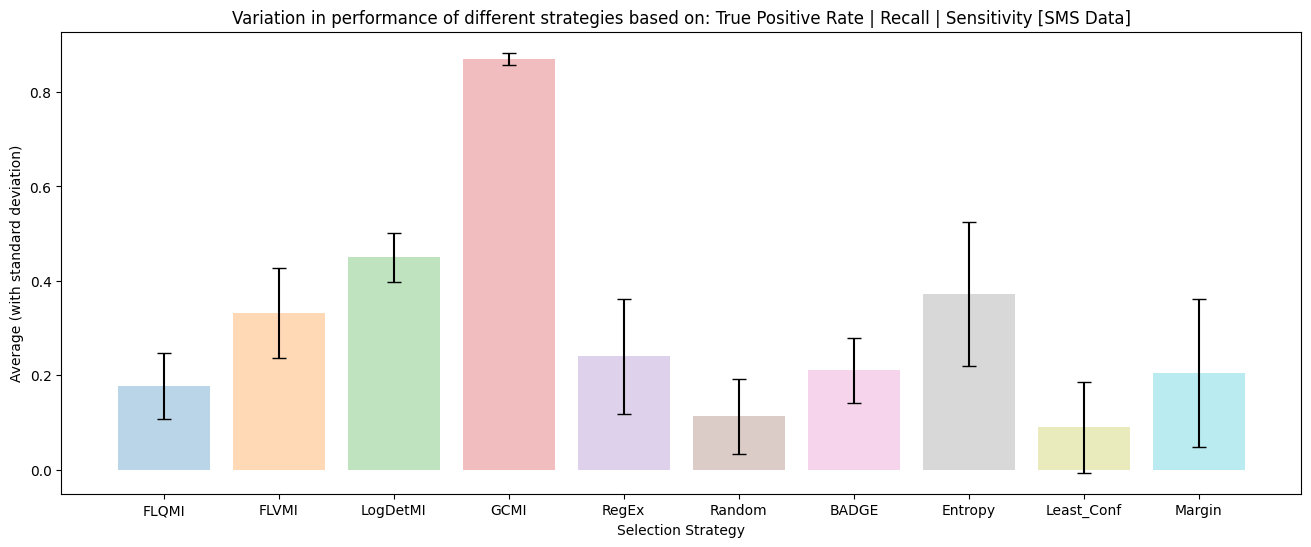

In [ ]:
graph_variance('tpr')

### Matthews Correlation Coefficient Variation

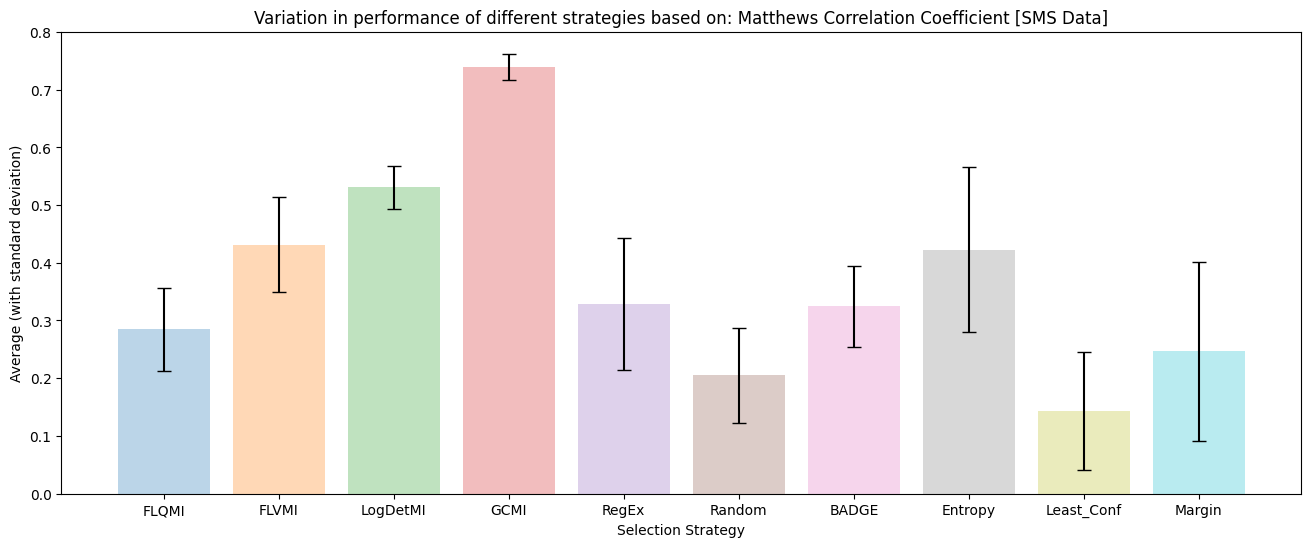

In [ ]:
graph_variance('mcc')